# Fama French 3 Factor Model

In [1]:
# import some useful packages
# these packages will be installed by default if you are using anaconda
import pandas as pd
import numpy as np
import datetime

# *Data Processing*

## Load Data

In [2]:
raw_df = pd.read_csv("/Users/daham/Desktop/Quantitative Investment/good_projects_for_git/Portfolio_using_Fama_French_factor/raw_data.csv")


In [3]:
# column selection
raw_df = raw_df.loc[:, ["datadate", "tic", "conm", "cogsq", "cshoq", "pstkq", "saleq", "teqq", "txditcq", "xintq", "xsgaq", 
                        "exchg", "prccq"]].copy()
# rename column
raw_df.columns = ["Date", "Ticker", "Company", "Cost of Goods Sold", "Common Shares Outstanding", "Preferred Stock Capital", 
                  "Sales/Turnover (Net)", "Stockholders Equity", "Deferred Taxes and Investment Tax Credit", 
                  "Interest and Related Expense", "Selling, General and Administrative Expenses", 
                  "Stock Exchange Code", "Close Price"]

raw_df.head()

Date Ticker   Company  Cost of Goods Sold  Common Shares Outstanding  \
0  05/31/2013    AIR  AAR CORP               465.9                     39.382   
1  08/31/2013    AIR  AAR CORP               401.8                     39.582   
2  11/30/2013    AIR  AAR CORP               281.0                     39.600   
3  02/28/2014    AIR  AAR CORP               305.0                     39.569   
4  05/31/2014    AIR  AAR CORP               319.0                     39.560   

   Preferred Stock Capital  Sales/Turnover (Net)  Stockholders Equity  \
0                      0.0                 583.6                919.5   
1                      0.0                 514.5                939.4   
2                      0.0                 374.2                967.2   
3                      0.0                 399.8                988.1   
4                      0.0                 420.6               1000.7   

   Deferred Taxes and Investment Tax Credit  Interest and Related Expense  \
0                                     138.2                          10.0   
1                                     146.8                          11.0   
2                                     153.5                           3.8   
3                                     143.2                           7.1   
4                                     162.2                           6.4   

   Selling, General and Administrative Expenses  Stock Exchange Code  \
0                                          52.5                   11   
1                                          47.7                   11   
2                                          34.9                   11   
3                                          37.7                   11   
4                                          46.0                   11   

   Close Price  
0        20.06  
1        25.09  
2        31.22  
3        28.90  
4        24.30

## Handle missing data

In [4]:
# drop if price or shares is missing
raw_df.dropna(axis=0, how='any', subset=['Close Price', 'Common Shares Outstanding'], inplace=True)


## Calculate ME, BE and Profitability

In [5]:
# market equity
raw_df['ME'] = raw_df['Close Price'] * raw_df['Common Shares Outstanding']
# book equity
raw_df['BE'] = raw_df['Stockholders Equity'] + raw_df['Deferred Taxes and Investment Tax Credit'].fillna(0) -\
raw_df['Preferred Stock Capital'].fillna(0)
# book to market ratio
raw_df['BE/ME'] = raw_df['BE'] / raw_df['ME']
# profitability
raw_df['PB'] = raw_df['Sales/Turnover (Net)'] - raw_df[['Cost of Goods Sold', 'Selling, General and Administrative Expenses',\
                                                        'Interest and Related Expense']].sum(axis=1, skipna=True)

# get cleaned dataset
clean_df = raw_df.iloc[:, [0,1,2,11,13,14,15,16]].copy()

In [6]:
clean_df.head()

Date Ticker   Company  Stock Exchange Code          ME      BE  \
0  05/31/2013    AIR  AAR CORP                   11   790.00292  1057.7   
1  08/31/2013    AIR  AAR CORP                   11   993.11238  1086.2   
2  11/30/2013    AIR  AAR CORP                   11  1236.31200  1120.7   
3  02/28/2014    AIR  AAR CORP                   11  1143.54410  1131.3   
4  05/31/2014    AIR  AAR CORP                   11   961.30800  1162.9   

      BE/ME    PB  
0  1.338856  55.2  
1  1.093733  54.0  
2  0.906486  54.5  
3  0.989293  50.0  
4  1.209706  49.2

As we can see, there are some NaNs in ME or BE or PB columns. Therefore, we are going to drop entire rows in this case.

In [7]:
clean_df.dropna(axis=0, how='any', subset=['ME', 'BE', 'PB'], inplace=True)

## *Calculate Factor Break Points (Satisfied point of Criteria)* 

In [8]:
# convert Date column to datetime
clean_df.loc[:, 'Date'] = pd.to_datetime(clean_df.loc[:, 'Date'], format='%m/%d/%Y')

In [9]:
# get data with month equals to May or Jun and listed on NYSE exchange for ME breakpoint calculation
me_df = clean_df.loc[((clean_df['Date'].dt.month == 5) | (clean_df['Date'].dt.month == 6))\
                     & (clean_df['Stock Exchange Code'] == 11)].copy()

In [10]:
## group1 = Small and Big (comparing to Market Equity of fiscal year end)

In [11]:
for yy in list(sorted(set(me_df['Date'].dt.year))):
    tmp_df = me_df.loc[me_df['Date'].dt.year == yy].copy()
    me_br_pt = np.nanmedian(tmp_df['ME'])
    clean_df.loc[clean_df['Date'].dt.year == yy, 'Group1'] = np.where(clean_df.loc[clean_df['Date'].dt.year == yy, 'ME'] <= me_br_pt, "Small", "Big")
    

In [12]:
# get data with month equals to Nov or Dec and listed on NYSE exchange for BE/ME breakpoint calculation
be_df = clean_df.loc[((clean_df['Date'].dt.month == 11) | (clean_df['Date'].dt.month == 12))\
                     & (clean_df['Stock Exchange Code'] == 11)].copy()

In [13]:
## group2 = High and Low (comparing to Book-to-Market ratio)

In [14]:
np.percentile(tmp_df['BE/ME'],65)

0.74161246511241619

In [15]:
for yy in list(sorted(set(be_df['Date'].dt.year))):
    tmp_df = be_df.loc[be_df['Date'].dt.year == yy].copy()
    be_br_pt = np.percentile(tmp_df['BE/ME'],65)
    clean_df.loc[clean_df['Date'].dt.year == yy, 'Group2'] = np.where(clean_df.loc[clean_df['Date'].dt.year == yy, 'BE/ME'] <= be_br_pt, "Growth", "Value")
    

In [16]:
clean_df

Date Ticker                      Company  Stock Exchange Code  \
0      2013-05-31    AIR                     AAR CORP                   11   
1      2013-08-31    AIR                     AAR CORP                   11   
2      2013-11-30    AIR                     AAR CORP                   11   
3      2014-02-28    AIR                     AAR CORP                   11   
4      2014-05-31    AIR                     AAR CORP                   11   
5      2014-08-31    AIR                     AAR CORP                   11   
6      2014-11-30    AIR                     AAR CORP                   11   
7      2015-02-28    AIR                     AAR CORP                   11   
8      2015-05-31    AIR                     AAR CORP                   11   
9      2015-08-31    AIR                     AAR CORP                   11   
10     2015-11-30    AIR                     AAR CORP                   11   
11     2016-02-29    AIR                     AAR CORP                   11   
12     2016-05-31    AIR                     AAR CORP                   11   
13     2016-08-31    AIR                     AAR CORP                   11   
14     2016-11-30    AIR                     AAR CORP                   11   
15     2017-02-28    AIR                     AAR CORP                   11   
16     2017-05-31    AIR                     AAR CORP                   11   
17     2017-08-31    AIR                     AAR CORP                   11   
18     2017-11-30    AIR                     AAR CORP                   11   
19     2018-02-28    AIR                     AAR CORP                   11   
20     2013-03-31    AAL  AMERICAN AIRLINES GROUP INC                   14   
21     2013-06-30    AAL  AMERICAN AIRLINES GROUP INC                   14   
22     2013-09-30    AAL  AMERICAN AIRLINES GROUP INC                   14   
23     2013-12-31    AAL  AMERICAN AIRLINES GROUP INC                   14   
24     2014-03-31    AAL  AMERICAN AIRLINES GROUP INC                   14   
25     2014-06-30    AAL  AMERICAN AIRLINES GROUP INC                   14   
26     2014-09-30    AAL  AMERICAN AIRLINES GROUP INC                   14   
27     2014-12-31    AAL  AMERICAN AIRLINES GROUP INC                   14   
28     2015-03-31    AAL  AMERICAN AIRLINES GROUP INC                   14   
29     2015-06-30    AAL  AMERICAN AIRLINES GROUP INC                   14   
...           ...    ...                          ...                  ...   
105059 2015-09-30    LPG               DORIAN LPG LTD                   11   
105060 2015-12-31    LPG               DORIAN LPG LTD                   11   
105061 2016-03-31    LPG               DORIAN LPG LTD                   11   
105062 2016-06-30    LPG               DORIAN LPG LTD                   11   
105063 2016-09-30    LPG               DORIAN LPG LTD                   11   
105064 2016-12-31    LPG               DORIAN LPG LTD                   11   
105065 2017-03-31    LPG               DORIAN LPG LTD                   11   
105066 2017-06-30    LPG               DORIAN LPG LTD                   11   
105067 2017-09-30    LPG               DORIAN LPG LTD                   11   
105068 2017-12-31    LPG               DORIAN LPG LTD                   11   
105077 2015-03-31   NOMD              NOMAD FOODS LTD                   11   
105081 2016-03-31   NOMD              NOMAD FOODS LTD                   11   
105082 2016-06-30   NOMD              NOMAD FOODS LTD                   11   
105083 2016-09-30   NOMD              NOMAD FOODS LTD                   11   
105084 2016-12-31   NOMD              NOMAD FOODS LTD                   11   
105085 2017-03-31   NOMD              NOMAD FOODS LTD                   11   
105086 2017-06-30   NOMD              NOMAD FOODS LTD                   11   
105087 2017-09-30   NOMD              NOMAD FOODS LTD                   11   
105097 2017-06-30   ARGX                   ARGEN-X SE                   14   
105111 2016-12-31    ATH           

In [17]:
small_50_percent_df=clean_df.loc[clean_df["Group1"]=='Small']
large_50_percent_df=clean_df.loc[clean_df["Group1"]=='Big']

for yy in list(sorted(set(me_df['Date'].dt.year))):
    tmp_df = be_df.loc[be_df['Date'].dt.year == yy].copy()
    be_br_pt = np.percentile(tmp_df['BE/ME'],65)
    small_50_percent_df.loc[small_50_percent_df['Date'].dt.year == yy, 'Group2'] = np.where(small_50_percent_df.loc[small_50_percent_df['Date'].dt.year == yy, 'BE/ME'] <= be_br_pt, "Growth", "Value")
    
for yy in list(sorted(set(me_df['Date'].dt.year))):
    tmp_df = be_df.loc[be_df['Date'].dt.year == yy].copy()
    be_br_pt = np.percentile(tmp_df['BE/ME'],65)
    large_50_percent_df.loc[large_50_percent_df['Date'].dt.year == yy, 'Group2'] = np.where(large_50_percent_df.loc[large_50_percent_df['Date'].dt.year == yy, 'BE/ME'] <= be_br_pt, "Growth", "Value")
   

/Users/daham/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


We are going to drop NaNs in Group1 or Group2. **Q: Why do we have NaNs in Group1 or Group2 when info shows they are non-null?**

In [18]:
# because we have 2018

In [19]:
category = clean_df.loc[pd.notnull(clean_df['Group1']) | pd.notnull(clean_df['Group2'])].copy().reset_index(drop=True)


### Porfolio 1: (10% Smallest Market Cap)

In [20]:
category['Date'].value_counts().sort_index()

2013-03-31    3162
2013-04-30     212
2013-05-31     114
2013-06-30    3254
2013-07-31     213
2013-08-31     111
2013-09-30    3257
2013-10-31     216
2013-11-30     116
2013-12-31    3381
2014-01-31     213
2014-02-28     113
2014-03-31    3413
2014-04-30     215
2014-05-31     114
2014-06-30    3538
2014-07-31     217
2014-08-31     113
2014-09-30    3549
2014-10-31     219
2014-11-30     112
2014-12-31    3686
2015-01-31     220
2015-02-28     111
2015-03-31    3670
2015-04-30     223
2015-05-31     113
2015-06-30    3788
2015-07-31     226
2015-08-31     112
2015-09-30    3781
2015-10-31     228
2015-11-30     115
2015-12-31    3913
2016-01-31     226
2016-02-29     112
2016-03-31    3866
2016-04-30     228
2016-05-31     112
2016-06-30    3967
2016-07-31     230
2016-08-31     112
2016-09-30    3948
2016-10-31     233
2016-11-30     114
2016-12-31    4070
2017-01-31     235
2017-02-28     110
2017-03-31    4024
2017-04-30     241
2017-05-31     112
2017-06-30    4155
2017-07-31  

In [21]:
## only smallest 10% are having weights every March.

## for example, there are 3162 stocks in 2013-03-31, but only 10%, 316 stocks has weights column

## THe reason why we check weights every March is we rebalance portfolio every March.

In [22]:
category['weights']=np.nan
for date in sorted(list(set(category["Date"]))):
    if date.month in [3]:
        date_smallest_10_percent=category.loc[category["Date"]==date,:].sort_values("ME",ascending=True).iloc[:int(round(len(category.loc[category["Date"]==date,:])/10))]
        date_smallest_10_percent["weights"]=date_smallest_10_percent["ME"]/date_smallest_10_percent["ME"].sum()
#         for index in date_smallest_10_percent.index:
        category.loc[date_smallest_10_percent.index,"weights"]=date_smallest_10_percent.loc[:,"weights"]

In [23]:
category.head()

Date Ticker   Company  Stock Exchange Code          ME      BE  \
0 2013-05-31    AIR  AAR CORP                   11   790.00292  1057.7   
1 2013-08-31    AIR  AAR CORP                   11   993.11238  1086.2   
2 2013-11-30    AIR  AAR CORP                   11  1236.31200  1120.7   
3 2014-02-28    AIR  AAR CORP                   11  1143.54410  1131.3   
4 2014-05-31    AIR  AAR CORP                   11   961.30800  1162.9   

      BE/ME    PB Group1 Group2  weights  
0  1.338856  55.2  Small  Value      NaN  
1  1.093733  54.0  Small  Value      NaN  
2  0.906486  54.5  Small  Value      NaN  
3  0.989293  50.0  Small  Value      NaN  
4  1.209706  49.2  Small  Value      NaN

### Porfolio 2: (35% Percentile Book/Market Ratio)

In [24]:
category["weights_2"]=np.nan
for date in sorted(list(set(category["Date"]))):
    if date.month in [3]:
        date_top_35_percent=category.loc[(category["Date"]==date)&(category["Group2"]=='Value'),:]
        date_top_35_percent["weights_2"]=date_top_35_percent["ME"]/date_top_35_percent["ME"].sum()
        category.loc[date_top_35_percent.index,"weights_2"]=date_top_35_percent.loc[:,"weights_2"]

/Users/daham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Porfolio 3: (35% Percentile Book/Market Ratio of Big and Small)

In [25]:
### Small:

In [26]:
small_50_percent_df["weights_2"]=np.nan
for date in sorted(list(set(category["Date"]))):
    if date.month in [3]:
        date_top_35_percent=small_50_percent_df.loc[(small_50_percent_df["Date"]==date)&(small_50_percent_df["Group2"]=='Value'),:]
        date_top_35_percent["weights_2"]=date_top_35_percent["ME"]/date_top_35_percent["ME"].sum()
        small_50_percent_df.loc[date_top_35_percent.index,"weights_2"]=date_top_35_percent.loc[:,"weights_2"]

/Users/daham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/daham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/daham/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [27]:
## Large

In [28]:
large_50_percent_df["weights_2"]=np.nan
for date in sorted(list(set(category["Date"]))):
    if date.month in [3]:
        date_top_35_percent=large_50_percent_df.loc[(large_50_percent_df["Date"]==date)&(large_50_percent_df["Group2"]=='Value'),:]
        date_top_35_percent["weights_2"]=date_top_35_percent["ME"]/date_top_35_percent["ME"].sum()
        large_50_percent_df.loc[date_top_35_percent.index,"weights_2"]=date_top_35_percent.loc[:,"weights_2"]

/Users/daham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/daham/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/daham/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [29]:
portfolio_df_3=small_50_percent_df.dropna(axis=0,how='any',subset=['weights_2'])
portfolio_df_4=large_50_percent_df.dropna(axis=0,how='any',subset=['weights_2'])
# portfolio_df_3=category.dropna(axis=0,how='any',subset=['weights_3'])

#### Data Processing for All Portfolios:

In [30]:
portfolio_df_1=category.dropna(axis=0,how='any',subset=['weights'])
portfolio_df_2=category.dropna(axis=0,how='any',subset=['weights_2'])
# portfolio_df_3=category.dropna(axis=0,how='any',subset=['weights_3'])

In [31]:
print(portfolio_df_1.loc[portfolio_df_1["Date"]=='2013-03-31','weights'].sum())
print(portfolio_df_1.loc[portfolio_df_1["Date"]=='2014-03-31','weights'].sum())
print(portfolio_df_1.loc[portfolio_df_1["Date"]=='2015-03-31','weights'].sum())
print(portfolio_df_1.loc[portfolio_df_1["Date"]=='2016-03-31','weights'].sum())
print(portfolio_df_1.loc[portfolio_df_1["Date"]=='2017-03-31','weights'].sum())


1.0
1.0
1.0
1.0
1.0


In [32]:
len(portfolio_df_1)

1813

In [33]:
print(len(portfolio_df_1.loc[portfolio_df_1["Date"]=='2013-03-31']))
print(len(portfolio_df_1.loc[portfolio_df_1["Date"]=='2014-03-31']))
print(len(portfolio_df_1.loc[portfolio_df_1["Date"]=='2015-03-31']))
print(len(portfolio_df_1.loc[portfolio_df_1["Date"]=='2016-03-31']))
print(len(portfolio_df_1.loc[portfolio_df_1["Date"]=='2017-03-31']))

316
341
367
387
402


In [34]:
#tmp = portfolio_df_1.loc[(portfolio_df_1['Date']>='2014-03-31') & (portfolio_df_1['Date']<='2017-04-30')]


In [35]:
#len(tmp)

In [36]:
portfolio_df_1.rename(columns = {'Date':'Rebalance Date'}, inplace=True)
portfolio_df_2.rename(columns = {'Date':'Rebalance Date'}, inplace=True)
portfolio_df_3.rename(columns = {'Date':'Rebalance Date'}, inplace=True)
portfolio_df_4.rename(columns = {'Date':'Rebalance Date'}, inplace=True)


/Users/daham/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [37]:
portfolio_df_1.head()

Rebalance Date Ticker             Company  Stock Exchange Code         ME  \
178     2013-03-31    ACU    ACME UNITED CORP                   12  38.337550   
182     2014-03-31    ACU    ACME UNITED CORP                   12  52.557219   
186     2015-03-31    ACU    ACME UNITED CORP                   12  60.528510   
198     2013-03-31    RWC  RELM WIRELESS CORP                   12  30.726833   
202     2014-03-31    RWC  RELM WIRELESS CORP                   12  42.953400   

         BE     BE/ME     PB Group1  Group2   weights  weights_2  
178  30.902  0.806050  0.673  Small   Value  0.005509   0.000006  
182  35.039  0.666683  0.857  Small  Growth  0.004581        NaN  
186  39.466  0.652023  1.196  Small  Growth  0.005147        NaN  
198  30.620  0.996523  0.868  Small   Value  0.004416   0.000005  
202  32.005  0.745110  0.897  Small   Value  0.003744   0.000007

## Value weighted index (Bench Mark)

In [38]:
benchmark = clean_df.loc[pd.notnull(clean_df['Group1']) | pd.notnull(clean_df['Group2'])].copy().reset_index(drop=True)


In [39]:
benchmark['weights']=np.nan
for date in sorted(list(set(category["Date"]))):
    if date.month in [3]:
        date_benchmark = benchmark.loc[benchmark["Date"]==date,:].sort_values("ME",ascending=True).iloc[:int(round(len(benchmark.loc[benchmark["Date"]==date,:])))]
        date_benchmark["weights"]=date_benchmark["ME"]/date_benchmark["ME"].sum()
#         for index in date_smallest_10_percent.index:
        benchmark.loc[date_benchmark.index,"weights"]=date_benchmark.loc[:,"weights"]
    

In [40]:
benchmark.head()

Date Ticker   Company  Stock Exchange Code          ME      BE  \
0 2013-05-31    AIR  AAR CORP                   11   790.00292  1057.7   
1 2013-08-31    AIR  AAR CORP                   11   993.11238  1086.2   
2 2013-11-30    AIR  AAR CORP                   11  1236.31200  1120.7   
3 2014-02-28    AIR  AAR CORP                   11  1143.54410  1131.3   
4 2014-05-31    AIR  AAR CORP                   11   961.30800  1162.9   

      BE/ME    PB Group1 Group2  weights  
0  1.338856  55.2  Small  Value      NaN  
1  1.093733  54.0  Small  Value      NaN  
2  0.906486  54.5  Small  Value      NaN  
3  0.989293  50.0  Small  Value      NaN  
4  1.209706  49.2  Small  Value      NaN

In [41]:
print(benchmark.loc[benchmark["Date"]=='2013-03-31','weights'].sum())
print(benchmark.loc[benchmark["Date"]=='2014-03-31','weights'].sum())
print(benchmark.loc[benchmark["Date"]=='2015-03-31','weights'].sum())
print(benchmark.loc[benchmark["Date"]=='2016-03-31','weights'].sum())
print(benchmark.loc[benchmark["Date"]=='2017-03-31','weights'].sum())

1.0
1.0
1.0
1.0
1.0


In [42]:
benchmark.rename(columns = {'Date':'Rebalance Date'}, inplace=True)

In [43]:
benchmark.head()

Rebalance Date Ticker   Company  Stock Exchange Code          ME      BE  \
0     2013-05-31    AIR  AAR CORP                   11   790.00292  1057.7   
1     2013-08-31    AIR  AAR CORP                   11   993.11238  1086.2   
2     2013-11-30    AIR  AAR CORP                   11  1236.31200  1120.7   
3     2014-02-28    AIR  AAR CORP                   11  1143.54410  1131.3   
4     2014-05-31    AIR  AAR CORP                   11   961.30800  1162.9   

      BE/ME    PB Group1 Group2  weights  
0  1.338856  55.2  Small  Value      NaN  
1  1.093733  54.0  Small  Value      NaN  
2  0.906486  54.5  Small  Value      NaN  
3  0.989293  50.0  Small  Value      NaN  
4  1.209706  49.2  Small  Value      NaN

# Simulation

The simulation begins in 2014 March and ends in 2017 December. The stocks within each category will be equally weighted. You can choose other weighting methods.

## Return Data Preprocessing

You can difinitely have different ways of implementing logic here. The code below is just a reference.

In [46]:
return_df = pd.read_csv("/Users/daham/Desktop/Quantitative Investment/good_projects_for_git/Portfolio_using_Fama_French_factor/monthly_total_return.csv")

return_df = return_df.loc[:, ["datadate", "tic", "conm", "exchg", "gsector", "trt1m"]].copy()

# rename column
# The column names below are copied from R to Python, however it is recommended to rename columns without white space in python.
return_df.columns = ["Date", "Ticker", "Company", "Stock Exchange Code", "GICS Sector", "M Total Return"]

# drop row that contain NA
return_df.dropna(inplace=True)

return_df.head()

Date Ticker   Company  Stock Exchange Code  GICS Sector  \
0  04/30/2015    AIR  AAR CORP                   11         20.0   
1  01/31/2017    AIR  AAR CORP                   11         20.0   
2  09/30/2017    AIR  AAR CORP                   11         20.0   
3  12/31/2015    AIR  AAR CORP                   11         20.0   
4  05/31/2016    AIR  AAR CORP                   11         20.0   

   M Total Return  
0         -1.2541  
1         -2.9803  
2          4.7698  
3          7.0440  
4          1.5391

In [47]:
# change Date column to datetime
return_df.loc[:, 'Date'] = pd.to_datetime(return_df.loc[:, 'Date'], format='%m/%d/%Y')

# sort by Ticker and Date column
return_df.sort_values(['Ticker', 'Date'], ascending=[True, True], inplace=True)


In [48]:
return_df.head()

Date Ticker                   Company  Stock Exchange Code  \
168670 2014-01-31      A  AGILENT TECHNOLOGIES INC                   11   
168669 2014-02-28      A  AGILENT TECHNOLOGIES INC                   11   
168668 2014-03-31      A  AGILENT TECHNOLOGIES INC                   11   
168667 2014-04-30      A  AGILENT TECHNOLOGIES INC                   11   
168666 2014-05-31      A  AGILENT TECHNOLOGIES INC                   11   

        GICS Sector  M Total Return  
168670         35.0          1.6786  
168669         35.0         -2.0980  
168668         35.0         -1.7741  
168667         35.0         -3.1259  
168666         35.0          5.3664

Here I use S_Period to indicate 3 simulation periods and compound the stocks in the same simulation period to get annualized returns.

In [49]:
# set a default value
return_df['S_Period'] = 0
# set values based on multiple conditions
return_df.loc[(return_df['Date']>='2014-04-30') & (return_df['Date']<='2015-03-31'), 'S_Period'] = 1
return_df.loc[(return_df['Date']>='2015-04-30') & (return_df['Date']<='2016-03-31'), 'S_Period'] = 2
return_df.loc[(return_df['Date']>='2016-04-30') & (return_df['Date']<='2017-03-31'), 'S_Period'] = 3
return_df.loc[(return_df['Date']>='2017-04-30') & (return_df['Date']<='2018-03-31'), 'S_Period'] = 4


In [50]:
# check
set(return_df.loc[return_df['S_Period']==1, 'Date'])

{Timestamp('2014-04-30 00:00:00'),
 Timestamp('2014-05-31 00:00:00'),
 Timestamp('2014-06-30 00:00:00'),
 Timestamp('2014-07-31 00:00:00'),
 Timestamp('2014-08-31 00:00:00'),
 Timestamp('2014-09-30 00:00:00'),
 Timestamp('2014-10-31 00:00:00'),
 Timestamp('2014-11-30 00:00:00'),
 Timestamp('2014-12-31 00:00:00'),
 Timestamp('2015-01-31 00:00:00'),
 Timestamp('2015-02-28 00:00:00'),
 Timestamp('2015-03-31 00:00:00')}

**Note: since we drop NA in *M Total Return* column, for some stocks we may not have complete 12 month returns**.
<br>

In that case, I simply drop those stocks for those simulation periods.

In [51]:
len(return_df)

227624

In [52]:
#return_df

In [53]:
# Check below.

In [54]:
portfolio_df_1[portfolio_df_1['Ticker']=='ABEO']

Rebalance Date Ticker                  Company  Stock Exchange Code  \
17112     2013-03-31   ABEO  ABEONA THERAPEUTICS INC                   14   
17116     2014-03-31   ABEO  ABEONA THERAPEUTICS INC                   14   

             ME      BE     BE/ME     PB Group1  Group2   weights  weights_2  
17112  12.16866 -13.606 -1.118118 -0.502  Small  Growth  0.001749        NaN  
17116  14.27470 -15.493 -1.085347 -1.328  Small  Growth  0.001244        NaN

In [55]:
return_df[return_df['Ticker']=='ABEO']

Date Ticker                  Company  Stock Exchange Code  \
46585 2014-12-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46584 2015-01-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46583 2015-02-28   ABEO  ABEONA THERAPEUTICS INC                   14   
46582 2015-03-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46581 2015-04-30   ABEO  ABEONA THERAPEUTICS INC                   14   
46580 2015-05-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46579 2015-06-30   ABEO  ABEONA THERAPEUTICS INC                   14   
46578 2015-07-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46577 2015-08-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46576 2015-09-30   ABEO  ABEONA THERAPEUTICS INC                   14   
46575 2015-10-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46574 2015-11-30   ABEO  ABEONA THERAPEUTICS INC                   14   
46573 2015-12-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46572 2016-01-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46571 2016-02-29   ABEO  ABEONA THERAPEUTICS INC                   14   
46570 2016-03-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46568 2016-04-30   ABEO  ABEONA THERAPEUTICS INC                   14   
46567 2016-05-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46566 2016-06-30   ABEO  ABEONA THERAPEUTICS INC                   14   
46565 2016-07-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46562 2016-08-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46561 2016-09-30   ABEO  ABEONA THERAPEUTICS INC                   14   
46560 2016-10-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46559 2016-11-30   ABEO  ABEONA THERAPEUTICS INC                   14   
46558 2016-12-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46557 2017-01-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46556 2017-02-28   ABEO  ABEONA THERAPEUTICS INC                   14   
46563 2017-03-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46555 2017-04-30   ABEO  ABEONA THERAPEUTICS INC                   14   
46554 2017-05-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46553 2017-06-30   ABEO  ABEONA THERAPEUTICS INC                   14   
46564 2017-07-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46552 2017-08-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46551 2017-09-30   ABEO  ABEONA THERAPEUTICS INC                   14   
46550 2017-10-31   ABEO  ABEONA THERAPEUTICS INC                   14   
46569 2017-11-30   ABEO  ABEONA THERAPEUTICS INC                   14   
46549 2017-12-31   ABEO  ABEONA THERAPEUTICS INC                   14   

       GICS Sector  M Total Return  S_Period  
46585         35.0        -50.7846         1  
46584         35.0         -8.9855         1  
46583         35.0          5.0955         1  
46582         35.0         -4.8485         1  
46581         35.0        -10.5096         2  
46580         35.0        179.3594         2  
46579         35.0        -35.5414         2  
46578         35.0         27.4704         2  
46577         35.0        -27.5969         2  
46576         35.0        -13.2762         2  
46575         35.0         -2.4691         2  
46574         35.0         17.7215         2  
46573         35.0        -27.7419         2  
46572         35.0        -22.3214         2  
46571         35.0        -14.1762         2  
46570         35.0         14.2857         2  
46568         35.0          6.2500         3  
46567         35.0          7.3529         3  
46566         35.0        -19.1781         3  
46565         35.0         13.9831         3  
46562         35.0         50.9294         3  
46561         35.0         47.7833         3  
46560         35.0          9.1667         3  
46559         35.0         -4.5802         3  
46558         35.0        -22.4000         3  
46557         3

In [56]:
return_df[return_df['Ticker']=='ABIO']

Date Ticker             Company  Stock Exchange Code  \
228090 2014-01-31   ABIO  ARCA BIOPHARMA INC                   14   
228089 2014-02-28   ABIO  ARCA BIOPHARMA INC                   14   
228088 2014-03-31   ABIO  ARCA BIOPHARMA INC                   14   
228087 2014-04-30   ABIO  ARCA BIOPHARMA INC                   14   
228086 2014-05-31   ABIO  ARCA BIOPHARMA INC                   14   
228085 2014-06-30   ABIO  ARCA BIOPHARMA INC                   14   
228084 2014-07-31   ABIO  ARCA BIOPHARMA INC                   14   
228083 2014-08-31   ABIO  ARCA BIOPHARMA INC                   14   
228082 2014-09-30   ABIO  ARCA BIOPHARMA INC                   14   
228081 2014-10-31   ABIO  ARCA BIOPHARMA INC                   14   
228080 2014-11-30   ABIO  ARCA BIOPHARMA INC                   14   
228079 2014-12-31   ABIO  ARCA BIOPHARMA INC                   14   
228078 2015-01-31   ABIO  ARCA BIOPHARMA INC                   14   
228077 2015-02-28   ABIO  ARCA BIOPHARMA INC                   14   
228076 2015-03-31   ABIO  ARCA BIOPHARMA INC                   14   
228075 2015-04-30   ABIO  ARCA BIOPHARMA INC                   14   
228074 2015-05-31   ABIO  ARCA BIOPHARMA INC                   14   
228073 2015-06-30   ABIO  ARCA BIOPHARMA INC                   14   
228072 2015-07-31   ABIO  ARCA BIOPHARMA INC                   14   
228071 2015-08-31   ABIO  ARCA BIOPHARMA INC                   14   
228070 2015-09-30   ABIO  ARCA BIOPHARMA INC                   14   
228068 2015-10-31   ABIO  ARCA BIOPHARMA INC                   14   
228067 2015-11-30   ABIO  ARCA BIOPHARMA INC                   14   
228066 2015-12-31   ABIO  ARCA BIOPHARMA INC                   14   
228065 2016-01-31   ABIO  ARCA BIOPHARMA INC                   14   
228062 2016-02-29   ABIO  ARCA BIOPHARMA INC                   14   
228061 2016-03-31   ABIO  ARCA BIOPHARMA INC                   14   
228060 2016-04-30   ABIO  ARCA BIOPHARMA INC                   14   
228059 2016-05-31   ABIO  ARCA BIOPHARMA INC                   14   
228058 2016-06-30   ABIO  ARCA BIOPHARMA INC                   14   
228057 2016-07-31   ABIO  ARCA BIOPHARMA INC                   14   
228056 2016-08-31   ABIO  ARCA BIOPHARMA INC                   14   
228063 2016-09-30   ABIO  ARCA BIOPHARMA INC                   14   
228055 2016-10-31   ABIO  ARCA BIOPHARMA INC                   14   
228054 2016-11-30   ABIO  ARCA BIOPHARMA INC                   14   
228053 2016-12-31   ABIO  ARCA BIOPHARMA INC                   14   
228064 2017-01-31   ABIO  ARCA BIOPHARMA INC                   14   
228052 2017-02-28   ABIO  ARCA BIOPHARMA INC                   14   
228051 2017-03-31   ABIO  ARCA BIOPHARMA INC                   14   
228050 2017-04-30   ABIO  ARCA BIOPHARMA INC                   14   
228069 2017-05-31   ABIO  ARCA BIOPHARMA INC                   14   
228049 2017-06-30   ABIO  ARCA BIOPHARMA INC                   14   
228048 2017-07-31   ABIO  ARCA BIOPHARMA INC                   14   
228047 2017-08-31   ABIO  ARCA BIOPHARMA INC                   14   
228046 2017-09-30   ABIO  ARCA BIOPHARMA INC                   14   
228045 2017-10-31   ABIO  ARCA BIOPHARMA INC                   14   
228044 2017-11-30   ABIO  ARCA BIOPHARMA INC                   14   
228043 2017-12-31   ABIO  ARCA BIOPHARMA INC                   14   

        GICS Sector  M Total Return  S_Period  
228090         35.0         16.0714         0  
228089         35.0         -3.5897         0  
228088         35.0         -1.0638         0  
228087         35.0        -13.4409         1  
228086         35.0         -8.6957         1  
228085         35.0         -0.6803         1  
228084         35.0         -2.0616         1  
228083         35.0         -2.0911         1  
228082         35.0        -11.4286         1  
228081         35.0         -9.6774         1  
228080         35.0        -26.9196         1  
228079         35.0         16.5058         1  
228078 

In [57]:
filtered_return = return_df.groupby(['Ticker', 'S_Period']).filter(lambda x: len(x) == 12).copy()


In [58]:
len(filtered_return)

161628

In [59]:
filtered_return.reset_index(drop=True, inplace=True)
return_df.tail()

Date Ticker                      Company  Stock Exchange Code  \
106923 2017-08-31   ZYNE  ZYNERBA PHARMACEUTICALS INC                   14   
106915 2017-09-30   ZYNE  ZYNERBA PHARMACEUTICALS INC                   14   
106914 2017-10-31   ZYNE  ZYNERBA PHARMACEUTICALS INC                   14   
106913 2017-11-30   ZYNE  ZYNERBA PHARMACEUTICALS INC                   14   
106928 2017-12-31   ZYNE  ZYNERBA PHARMACEUTICALS INC                   14   

        GICS Sector  M Total Return  S_Period  
106923         35.0        -54.9645         4  
106915         35.0         31.6535         4  
106914         35.0         17.2249         4  
106913         35.0         40.5102         4  
106928         35.0         -9.0777         4

## Aggragate Monthly Return

In [60]:
filtered_return.loc[:, 'M Total Return'] = filtered_return.loc[:, 'M Total Return']/100+1


In [61]:
filtered_return.head()

Date Ticker                   Company  Stock Exchange Code  \
0 2014-04-30      A  AGILENT TECHNOLOGIES INC                   11   
1 2014-05-31      A  AGILENT TECHNOLOGIES INC                   11   
2 2014-06-30      A  AGILENT TECHNOLOGIES INC                   11   
3 2014-07-31      A  AGILENT TECHNOLOGIES INC                   11   
4 2014-08-31      A  AGILENT TECHNOLOGIES INC                   11   

   GICS Sector  M Total Return  S_Period  
0         35.0        0.968741         1  
1         35.0        1.053664         1  
2         35.0        1.011099         1  
3         35.0        0.976497         1  
4         35.0        1.019076         1

In [62]:
filtered_return.groupby(['Ticker', 'S_Period'])

In [63]:
filtered_return['Annual Return'] = filtered_return.groupby(['Ticker', 'S_Period'])['M Total Return'].transform('prod')


In [64]:
filtered_return.head(13)

Date Ticker                   Company  Stock Exchange Code  \
0  2014-04-30      A  AGILENT TECHNOLOGIES INC                   11   
1  2014-05-31      A  AGILENT TECHNOLOGIES INC                   11   
2  2014-06-30      A  AGILENT TECHNOLOGIES INC                   11   
3  2014-07-31      A  AGILENT TECHNOLOGIES INC                   11   
4  2014-08-31      A  AGILENT TECHNOLOGIES INC                   11   
5  2014-09-30      A  AGILENT TECHNOLOGIES INC                   11   
6  2014-10-31      A  AGILENT TECHNOLOGIES INC                   11   
7  2014-11-30      A  AGILENT TECHNOLOGIES INC                   11   
8  2014-12-31      A  AGILENT TECHNOLOGIES INC                   11   
9  2015-01-31      A  AGILENT TECHNOLOGIES INC                   11   
10 2015-02-28      A  AGILENT TECHNOLOGIES INC                   11   
11 2015-03-31      A  AGILENT TECHNOLOGIES INC                   11   
12 2015-04-30      A  AGILENT TECHNOLOGIES INC                   11   

    GICS Sector  M Total Return  S_Period  Annual Return  
0          35.0        0.968741         1       1.021380  
1          35.0        1.053664         1       1.021380  
2          35.0        1.011099         1       1.021380  
3          35.0        0.976497         1       1.021380  
4          35.0        1.019076         1       1.021380  
5          35.0        0.999160         1       1.021380  
6          35.0        0.970165         1       1.021380  
7          35.0        1.050018         1       1.021380  
8          35.0        0.957885         1       1.021380  
9          35.0        0.925012         1       1.021380  
10         35.0        1.117554         1       1.021380  
11         35.0        0.986733         1       1.021380  
12         35.0        0.995668         2       0.967025

**Note: All we need is rebalancing date (YYYY-03-31) information. So let's drop some rows.**

In [65]:
annual_return = filtered_return.loc[filtered_return['Date'].dt.month==3].reset_index(drop=True).copy()


In [66]:
annual_return.head()

Date Ticker                   Company  Stock Exchange Code  \
0 2015-03-31      A  AGILENT TECHNOLOGIES INC                   11   
1 2016-03-31      A  AGILENT TECHNOLOGIES INC                   11   
2 2017-03-31      A  AGILENT TECHNOLOGIES INC                   11   
3 2015-03-31   AA.3                 ALCOA INC                   11   
4 2016-03-31   AA.3                 ALCOA INC                   11   

   GICS Sector  M Total Return  S_Period  Annual Return  
0         35.0        0.986733         1       1.021380  
1         35.0        1.066934         2       0.967025  
2         35.0        1.033177         3       1.344383  
3         15.0        0.873563         1       1.011713  
4         15.0        1.072788         2       0.750528

In [67]:
## This should be done first, because we want to see 1-year-later returns of portfolios.

In [68]:
annual_return['Rebalance Date'] = annual_return['Date'].apply(lambda x: x - pd.DateOffset(years=1))


In [69]:
annual_return.head()

Date Ticker                   Company  Stock Exchange Code  \
0 2015-03-31      A  AGILENT TECHNOLOGIES INC                   11   
1 2016-03-31      A  AGILENT TECHNOLOGIES INC                   11   
2 2017-03-31      A  AGILENT TECHNOLOGIES INC                   11   
3 2015-03-31   AA.3                 ALCOA INC                   11   
4 2016-03-31   AA.3                 ALCOA INC                   11   

   GICS Sector  M Total Return  S_Period  Annual Return Rebalance Date  
0         35.0        0.986733         1       1.021380     2014-03-31  
1         35.0        1.066934         2       0.967025     2015-03-31  
2         35.0        1.033177         3       1.344383     2016-03-31  
3         15.0        0.873563         1       1.011713     2014-03-31  
4         15.0        1.072788         2       0.750528     2015-03-31

## Merge 1st Portfolio Table and Return Table

In [70]:
port_1_res = pd.merge(annual_return, portfolio_df_1, on=['Rebalance Date', 'Ticker', 'Company'], how='inner')
port_1_res.head(20)

Date Ticker                      Company  Stock Exchange Code_x  \
0  2017-03-31   AAMC   ALTISOURCE ASSET MGMT CORP                     12   
1  2015-03-31   ABAC      RENMIN TIANLI GROUP INC                     14   
2  2016-03-31   ABAC      RENMIN TIANLI GROUP INC                     14   
3  2017-03-31   ABAC      RENMIN TIANLI GROUP INC                     14   
4  2015-03-31   ABIO           ARCA BIOPHARMA INC                     14   
5  2016-03-31   ABIO           ARCA BIOPHARMA INC                     14   
6  2017-03-31   ABIO           ARCA BIOPHARMA INC                     14   
7  2015-03-31    ACU             ACME UNITED CORP                     12   
8  2016-03-31    ACU             ACME UNITED CORP                     12   
9  2015-03-31    ACY             AEROCENTURY CORP                     12   
10 2016-03-31    ACY             AEROCENTURY CORP                     12   
11 2017-03-31    ACY             AEROCENTURY CORP                     12   
12 2016-03-31   ADMP  ADAMIS PHARMACEUTICALS CORP                     14   
13 2017-03-31   AEMD          AETHLON MEDICAL INC                     14   
14 2015-03-31   AETI   AMERICAN ELECTRIC TECH INC                     14   
15 2016-03-31   AETI   AMERICAN ELECTRIC TECH INC                     14   
16 2017-03-31   AETI   AMERICAN ELECTRIC TECH INC                     14   
17 2015-03-31    AEY   ADDVANTAGE TECHNOLOGIES GP                     14   
18 2016-03-31    AEY   ADDVANTAGE TECHNOLOGIES GP                     14   
19 2017-03-31    AEY   ADDVANTAGE TECHNOLOGIES GP                     14   

    GICS Sector  M Total Return  S_Period  Annual Return Rebalance Date  \
0          60.0        1.070413         3       6.377125     2016-03-31   
1          30.0        1.006711         1       0.806452     2014-03-31   
2          30.0        1.189655         2       0.460000     2015-03-31   
3          30.0        0.821429         3       0.833334     2016-03-31   
4          35.0        1.128714         1       0.424784     2014-03-31   
5          35.0        1.008721         2       0.627407     2015-03-31   
6          35.0        1.000000         3       0.734871     2016-03-31   
7          20.0        0.954758         1       1.140408     2014-03-31   
8          20.0        1.075916         2       0.915595     2015-03-31   
9          20.0        1.316783         1       0.744944     2014-03-31   
10         20.0        0.843704         2       0.811223     2015-03-31   
11         20.0        0.981974         3       0.911052     2016-03-31   
12         35.0        1.056897         2       1.555840     2015-03-31   
13         35.0        0.866233         3       0.609271     2016-03-31   
14         20.0        1.087293         1       0.620030     2014-03-31   
15         20.0        0.701550         2       0.429929     2015-03-31   
16         20.0        1.131579         3       1.187846     2016-03-31   
17         45.0        0.971074         1       0.707831     2014-03-31   
18         45.0        1.187500         2       0.808511     2015-03-31   
19         45.0        1.064246         3       1.002631     2016-03-31   

    Stock Exchange Code_y         ME       BE     BE/ME     PB Group1  Group2  \
0                      12  22.431800 -184.637 -8.231038 -1.245  Small  Growth   
1                      14  31.553040   49.392  1.565364  0.863  Small   Value   
2                      14  49.774500   97.196  1.952727  0.111  Small   Value   
3                      14  22.046880   93.147  4.224952  1.557  Small   Value   
4                      14  39.063720   21.534  0.551253 -2.388  Small  Growth   
5                      14  16.748540   12.127  0.724063 -2.741  Small  Growth   
6                      14  31.427790   34.584  1.100427 -3.663  Small   Value   
7                      12  52.557219   35.039  0.666683  0.857  Small  Growth   
8                      12  60.528510   39.466  0.652023  1.196  Small  Growth   
9                      12 

In [71]:
# select useful columns
port_1_res = port_1_res.loc[:, ['Rebalance Date', 'Date', 'Ticker', 'Company', 'GICS Sector', 'Group1', 'Group2', 'Annual Return','weights']]
port_1_res.tail()


Rebalance Date       Date Ticker                     Company  GICS Sector  \
936     2014-03-31 2015-03-31   XTNT  XTANT MEDICAL HOLDINGS INC         35.0   
937     2016-03-31 2017-03-31   XTNT  XTANT MEDICAL HOLDINGS INC         35.0   
938     2015-03-31 2016-03-31   XXII      22ND CENTURY GROUP INC         30.0   
939     2014-03-31 2015-03-31   YTEN      YIELD10 BIOSCIENCE INC         15.0   
940     2016-03-31 2017-03-31   ZSAN          ZOSANO PHARMA CORP         35.0   

    Group1  Group2  Annual Return   weights  
936  Small  Growth       0.488094  0.004025  
937  Small  Growth       0.229852  0.003648  
938  Small  Growth       0.910466  0.004725  
939  Small  Growth       0.476924  0.003953  
940  Small  Growth       0.826087  0.003114

In [72]:
len(port_1_res)

941

In [73]:
print(len(port_1_res.loc[port_1_res["Date"]=='2015-03-31']))
print(len(port_1_res.loc[port_1_res["Date"]=='2016-03-31']))
print(len(port_1_res.loc[port_1_res["Date"]=='2017-03-31']))
print(len(port_1_res.loc[port_1_res["Date"]=='2018-03-31']))

280
325
336
0


In [74]:
port_1_res[port_1_res['Rebalance Date']=='2014-03-31']

Rebalance Date       Date Ticker                       Company  \
1       2014-03-31 2015-03-31   ABAC       RENMIN TIANLI GROUP INC   
4       2014-03-31 2015-03-31   ABIO            ARCA BIOPHARMA INC   
7       2014-03-31 2015-03-31    ACU              ACME UNITED CORP   
9       2014-03-31 2015-03-31    ACY              AEROCENTURY CORP   
14      2014-03-31 2015-03-31   AETI    AMERICAN ELECTRIC TECH INC   
17      2014-03-31 2015-03-31    AEY    ADDVANTAGE TECHNOLOGIES GP   
22      2014-03-31 2015-03-31   AHPI   ALLIED HEALTHCARE PRODS INC   
26      2014-03-31 2015-03-31   AIRI      AIR INDUSTRIES GROUP INC   
27      2014-03-31 2015-03-31   AIRT                     AIR T INC   
29      2014-03-31 2015-03-31   AKER         AKERS BIOSCIENCES INC   
33      2014-03-31 2015-03-31    ALN          AMERICAN LORAIN CORP   
38      2014-03-31 2015-03-31    AMS    AMERICAN SHARED HSPTL SERV   
42      2014-03-31 2015-03-31   ANCB             ANCHOR BANCORP/WA   
47      2014-03-31 2015-03-31    APT            ALPHA PRO TECH LTD   
50      2014-03-31 2015-03-31   APWC  ASIA PACIFIC WIRE&CABLE CORP   
51      2014-03-31 2015-03-31   ARCI  APPLIANCE RECYCLING CTR AMER   
54      2014-03-31 2015-03-31   ASMB      ASSEMBLY BIOSCIENCES INC   
56      2014-03-31 2015-03-31   ASTC                ASTROTECH CORP   
59      2014-03-31 2015-03-31   ASUR            ASURE SOFTWARE INC   
63      2014-03-31 2015-03-31   ATLC      ATLANTICUS HOLDINGS CORP   
65      2014-03-31 2015-03-31   ATOS           ATOSSA GENETICS INC   
68      2014-03-31 2015-03-31    ATV  ACORN INTERNATIONAL INC -ADR   
69      2014-03-31 2015-03-31   AUMN            GOLDEN MINERALS CO   
72      2014-03-31 2015-03-31    AWX          AVALON HOLDINGS CORP   
75      2014-03-31 2015-03-31   AXGN                    AXOGEN INC   
76      2014-03-31 2015-03-31   BASI     BIOANALYTICAL SYSTEMS INC   
79      2014-03-31 2015-03-31    BDL     FLANIGANS ENTERPRISES INC   
82      2014-03-31 2015-03-31    BDR       BLONDER TONGUE LABS INC   
85      2014-03-31 2015-03-31    BGI               BIRKS GROUP INC   
88      2014-03-31 2015-03-31   BIOC                   BIOCEPT INC   
..             ...        ...    ...                           ...   
836     2014-03-31 2015-03-31   SUMR             SUMMER INFANT INC   
839     2014-03-31 2015-03-31   SVBI            SEVERN BANCORP INC   
841     2014-03-31 2015-03-31    SVT              SERVOTRONICS INC   
845     2014-03-31 2015-03-31   SYPR          SYPRIS SOLUTIONS INC   
849     2014-03-31 2015-03-31   TAIT     TAITRON COMPONENTS  -CL A   
853     2014-03-31 2015-03-31   TCCO   TECHNICAL COMMUNICATIONS CP   
858     2014-03-31 2015-03-31    TGC                  TENGASCO INC   
863     2014-03-31 2015-03-31   THST              TRUETT-HURST INC   
866     2014-03-31 2015-03-31    TIK    TEL-INSTRUMENT ELECTRONICS   
873     2014-03-31 2015-03-31    TRT       TRIO-TECH INTERNATIONAL   
879     2014-03-31 2015-03-31   UBCP         UNITED BANCORP INC/OH   
881     2014-03-31 2015-03-31   UBOH      UNITED BANCSHARES INC/OH   
883     2014-03-31 2015-03-31   UCBA      UNITED COMMUNITY BANCORP   
890     2014-03-31 2015-03-31    UUU  UNIVERSAL SECURITY INSTRUMNT   
893     2014-03-31 2015-03-31   VBFC   VILLAGE BANK AND TRUST FINL   
896     2014-03-31 2015-03-31   VCEL                  VERICEL CORP   
897     2014-03-31 2015-03-31    VGZ               VISTA GOLD CORP   
901     2014-03-31 2015-03-31    VII          VICON INDUSTRIES INC   
905     2014-03-31 2015-03-31   WEBK         WELLESLEY BANCORP INC   
909     2014-03-31 2015-03-31   WHLR   WHEELER REAL ESTATE INVT TR   
911     2014-03-31 2015-03-31   WLDN             WILLDAN GROUP INC   
912     2014-03-31 2015-03-31   WMLP  WESTMORELAND RES PARTNERS LP   
916     2014-03-31 2015-03-31   WVFC            WVS FINANCIAL CORP   
919     2014-03-31 2015-03-31   WVVI   WILLAMETTE VALLEY VINEYARDS   
924     2014-03-31 2015-03-31   XGTI             XG TECHNOLOGY INC   
926     2014-0

In [75]:
port_1_res.loc[port_1_res["Rebalance Date"]=='2015-03-31','weights'].sum()

0.91163845801669563

In [76]:
port_1_res

Rebalance Date       Date Ticker                       Company  \
0       2016-03-31 2017-03-31   AAMC    ALTISOURCE ASSET MGMT CORP   
1       2014-03-31 2015-03-31   ABAC       RENMIN TIANLI GROUP INC   
2       2015-03-31 2016-03-31   ABAC       RENMIN TIANLI GROUP INC   
3       2016-03-31 2017-03-31   ABAC       RENMIN TIANLI GROUP INC   
4       2014-03-31 2015-03-31   ABIO            ARCA BIOPHARMA INC   
5       2015-03-31 2016-03-31   ABIO            ARCA BIOPHARMA INC   
6       2016-03-31 2017-03-31   ABIO            ARCA BIOPHARMA INC   
7       2014-03-31 2015-03-31    ACU              ACME UNITED CORP   
8       2015-03-31 2016-03-31    ACU              ACME UNITED CORP   
9       2014-03-31 2015-03-31    ACY              AEROCENTURY CORP   
10      2015-03-31 2016-03-31    ACY              AEROCENTURY CORP   
11      2016-03-31 2017-03-31    ACY              AEROCENTURY CORP   
12      2015-03-31 2016-03-31   ADMP   ADAMIS PHARMACEUTICALS CORP   
13      2016-03-31 2017-03-31   AEMD           AETHLON MEDICAL INC   
14      2014-03-31 2015-03-31   AETI    AMERICAN ELECTRIC TECH INC   
15      2015-03-31 2016-03-31   AETI    AMERICAN ELECTRIC TECH INC   
16      2016-03-31 2017-03-31   AETI    AMERICAN ELECTRIC TECH INC   
17      2014-03-31 2015-03-31    AEY    ADDVANTAGE TECHNOLOGIES GP   
18      2015-03-31 2016-03-31    AEY    ADDVANTAGE TECHNOLOGIES GP   
19      2016-03-31 2017-03-31    AEY    ADDVANTAGE TECHNOLOGIES GP   
20      2015-03-31 2016-03-31   AEZS          AETERNA ZENTARIS INC   
21      2016-03-31 2017-03-31   AEZS          AETERNA ZENTARIS INC   
22      2014-03-31 2015-03-31   AHPI   ALLIED HEALTHCARE PRODS INC   
23      2015-03-31 2016-03-31   AHPI   ALLIED HEALTHCARE PRODS INC   
24      2016-03-31 2017-03-31   AHPI   ALLIED HEALTHCARE PRODS INC   
25      2016-03-31 2017-03-31   AIPT    PRECISION THERAPEUTICS INC   
26      2014-03-31 2015-03-31   AIRI      AIR INDUSTRIES GROUP INC   
27      2014-03-31 2015-03-31   AIRT                     AIR T INC   
28      2015-03-31 2016-03-31   AIRT                     AIR T INC   
29      2014-03-31 2015-03-31   AKER         AKERS BIOSCIENCES INC   
..             ...        ...    ...                           ...   
911     2014-03-31 2015-03-31   WLDN             WILLDAN GROUP INC   
912     2014-03-31 2015-03-31   WMLP  WESTMORELAND RES PARTNERS LP   
913     2016-03-31 2017-03-31   WMLP  WESTMORELAND RES PARTNERS LP   
914     2015-03-31 2016-03-31    WTT    WIRELESS TELECOM GROUP INC   
915     2016-03-31 2017-03-31    WTT    WIRELESS TELECOM GROUP INC   
916     2014-03-31 2015-03-31   WVFC            WVS FINANCIAL CORP   
917     2015-03-31 2016-03-31   WVFC            WVS FINANCIAL CORP   
918     2016-03-31 2017-03-31   WVFC            WVS FINANCIAL CORP   
919     2014-03-31 2015-03-31   WVVI   WILLAMETTE VALLEY VINEYARDS   
920     2015-03-31 2016-03-31   WVVI   WILLAMETTE VALLEY VINEYARDS   
921     2016-03-31 2017-03-31   WVVI   WILLAMETTE VALLEY VINEYARDS   
922     2015-03-31 2016-03-31    WWR       WESTWATER RESOURCES INC   
923     2016-03-31 2017-03-31    WWR       WESTWATER RESOURCES INC   
924     2014-03-31 2015-03-31   XGTI             XG TECHNOLOGY INC   
925     2016-03-31 2017-03-31   XGTI             XG TECHNOLOGY INC   
926     2014-03-31 2015-03-31    XPL  SOLITARIO EXPLORATION & RLTY   
927     2015-03-31 2016-03-31    XPL  SOLITARIO EXPLORATION & RLTY   
928     2016-03-31 2017-03-31    XPL  SOLITARIO EXPLORATION & RLTY   
929     2014-03-31 2015-03-31   XPLR      XPLORE TECHNOLOGIES CORP   
930     2016-03-31 2017-03-31   XPLR      XPLORE TECHNOLOGIES CORP   
931     2015-03-31 2016-03-31   XSPA            XPRESSPA GROUP INC   
932     2016-03-31 2017-03-31   XSPA            XPRESSPA GROUP INC   
933     2014-03-31 2015-03-31   XTLB        XTL BIOPHARMACEUTICALS   
934     2015-03-31 2016-03-31   XTLB        XTL BIOPHARMACEUTICALS   
935     2016-03-31 2017-03-31   XTLB        XTL BIOPHARMACEUTICALS   
936     2014-0

## Merge 2nd Portfolio Table and Return Table

In [77]:
port_2_res = pd.merge(annual_return, portfolio_df_2, on=['Rebalance Date', 'Ticker', 'Company'], how='inner')
port_2_res.head(20)

Date Ticker                       Company  Stock Exchange Code_x  \
0  2016-03-31   AABA                    ALTABA INC                     14   
1  2017-03-31   AABA                    ALTABA INC                     14   
2  2016-03-31   AAMC    ALTISOURCE ASSET MGMT CORP                     12   
3  2015-03-31   AAME        ATLANTIC AMERICAN CORP                     14   
4  2016-03-31   AAME        ATLANTIC AMERICAN CORP                     14   
5  2017-03-31   AAME        ATLANTIC AMERICAN CORP                     14   
6  2017-03-31    AAN                   AARON'S INC                     11   
7  2015-03-31   AAWW  ATLAS AIR WORLDWIDE HLDG INC                     14   
8  2016-03-31   AAWW  ATLAS AIR WORLDWIDE HLDG INC                     14   
9  2017-03-31   AAWW  ATLAS AIR WORLDWIDE HLDG INC                     14   
10 2015-03-31   ABAC       RENMIN TIANLI GROUP INC                     14   
11 2016-03-31   ABAC       RENMIN TIANLI GROUP INC                     14   
12 2017-03-31   ABAC       RENMIN TIANLI GROUP INC                     14   
13 2016-03-31   ABDC         ALCENTRA CAPITAL CORP                     14   
14 2017-03-31   ABDC         ALCENTRA CAPITAL CORP                     14   
15 2017-03-31   ABEO       ABEONA THERAPEUTICS INC                     14   
16 2017-03-31   ABIO            ARCA BIOPHARMA INC                     14   
17 2015-03-31    ABR        ARBOR REALTY TRUST INC                     11   
18 2016-03-31    ABR        ARBOR REALTY TRUST INC                     11   
19 2017-03-31    ABR        ARBOR REALTY TRUST INC                     11   

    GICS Sector  M Total Return  S_Period  Annual Return Rebalance Date  \
0          45.0        1.157911         2       0.828401     2015-03-31   
1          45.0        1.016426         3       1.260798     2016-03-31   
2          60.0        0.694118         2       0.063739     2015-03-31   
3          40.0        1.007500         1       1.112892     2014-03-31   
4          40.0        1.067146         2       1.109794     2015-03-31   
5          40.0        1.038961         3       0.903178     2016-03-31   
6          25.0        1.091184         3       1.189552     2016-03-31   
7          20.0        0.948622         1       1.219735     2014-03-31   
8          20.0        1.167357         2       0.982567     2015-03-31   
9          20.0        0.975374         3       1.311805     2016-03-31   
10         30.0        1.006711         1       0.806452     2014-03-31   
11         30.0        1.189655         2       0.460000     2015-03-31   
12         30.0        0.821429         3       0.833334     2016-03-31   
13         40.0        1.156522         2       0.979083     2015-03-31   
14         40.0        1.129704         3       1.316189     2016-03-31   
15         35.0        0.925926         3       1.953126     2016-03-31   
16         35.0        1.000000         3       0.734871     2016-03-31   
17         40.0        0.973501         1       1.084796     2014-03-31   
18         40.0        1.017647         2       1.058732     2015-03-31   
19         40.0        1.158537         3       1.344837     2016-03-31   

    Stock Exchange Code_y            ME         BE     BE/ME       PB Group1  \
0                      14  41646.037225  46623.380  1.119515   95.847    Big   
1                      14  34905.045690  28515.172  0.816936    9.788    Big   
2                      12    408.581910   1133.944  2.775316   20.453  Small   
3                      14     76.778520    102.008  1.328601    1.206  Small   
4                      14     82.937400    110.774  1.335634    1.293  Small   
5                      14     90.739950    103.944  1.145515    1.667  Small   
6                      11   1825.999900   1724.593  0.944465  445.667  Small   
7                      14    887.393200   1674.455  1.886937   37.862  Small   
8                      14   1075.629060   1804.561  1.677680   65.093  Small   
9              

In [78]:
# select useful columns
port_2_res = port_2_res.loc[:, ['Rebalance Date', 'Date', 'Ticker', 'Company', 'GICS Sector', 'Group1', 'Group2', 'Annual Return','weights_2']]
port_2_res.tail()

Rebalance Date       Date Ticker                      Company  \
3544     2016-03-31 2017-03-31   ZION         ZIONS BANCORPORATION   
3545     2016-03-31 2017-03-31   ZNGA                    ZYNGA INC   
3546     2014-03-31 2015-03-31     ZX  CHINA ZENIX AUTO INTL  -ADR   
3547     2015-03-31 2016-03-31     ZX  CHINA ZENIX AUTO INTL  -ADR   
3548     2016-03-31 2017-03-31     ZX  CHINA ZENIX AUTO INTL  -ADR   

      GICS Sector Group1 Group2  Annual Return  weights_2  
3544         40.0    Big  Value       1.749697   0.000725  
3545         45.0  Small  Value       1.250002   0.000291  
3546         25.0  Small  Value       0.461201   0.000021  
3547         25.0  Small  Value       0.966467   0.000012  
3548         25.0  Small  Value       1.324347   0.000009

## 3&4 Merge 3rd and 4th Portfolio Table and Return Table

In [79]:
port_3_res = pd.merge(annual_return, portfolio_df_3, on=['Rebalance Date', 'Ticker', 'Company'], how='inner')
port_3_res.head(30)

Date Ticker                       Company  Stock Exchange Code_x  \
0  2016-03-31   AAMC    ALTISOURCE ASSET MGMT CORP                     12   
1  2015-03-31   AAME        ATLANTIC AMERICAN CORP                     14   
2  2016-03-31   AAME        ATLANTIC AMERICAN CORP                     14   
3  2017-03-31   AAME        ATLANTIC AMERICAN CORP                     14   
4  2017-03-31    AAN                   AARON'S INC                     11   
5  2015-03-31   AAWW  ATLAS AIR WORLDWIDE HLDG INC                     14   
6  2016-03-31   AAWW  ATLAS AIR WORLDWIDE HLDG INC                     14   
7  2017-03-31   AAWW  ATLAS AIR WORLDWIDE HLDG INC                     14   
8  2015-03-31   ABAC       RENMIN TIANLI GROUP INC                     14   
9  2016-03-31   ABAC       RENMIN TIANLI GROUP INC                     14   
10 2017-03-31   ABAC       RENMIN TIANLI GROUP INC                     14   
11 2016-03-31   ABDC         ALCENTRA CAPITAL CORP                     14   
12 2017-03-31   ABDC         ALCENTRA CAPITAL CORP                     14   
13 2017-03-31   ABEO       ABEONA THERAPEUTICS INC                     14   
14 2017-03-31   ABIO            ARCA BIOPHARMA INC                     14   
15 2015-03-31    ABR        ARBOR REALTY TRUST INC                     11   
16 2016-03-31    ABR        ARBOR REALTY TRUST INC                     11   
17 2017-03-31    ABR        ARBOR REALTY TRUST INC                     11   
18 2017-03-31   ABTX     ALLEGIANCE BANCSHARES INC                     14   
19 2017-03-31   ABUS        ARBUTUS BIOPHARMA CORP                     14   
20 2017-03-31     AC  ASSOCIATED CAPITAL GROUP INC                     11   
21 2017-03-31   ACBI   ATLANTIC CAP BANCSHARES INC                     14   
22 2015-03-31   ACCO              ACCO BRANDS CORP                     11   
23 2017-03-31   ACCO              ACCO BRANDS CORP                     11   
24 2015-03-31   ACFC   ATLANTIC COAST FINANCIAL CP                     14   
25 2016-03-31   ACFC   ATLANTIC COAST FINANCIAL CP                     14   
26 2017-03-31   ACFC   ATLANTIC COAST FINANCIAL CP                     14   
27 2015-03-31   ACLS      AXCELIS TECHNOLOGIES INC                     14   
28 2015-03-31   ACNB                     ACNB CORP                     14   
29 2016-03-31   ACNB                     ACNB CORP                     14   

    GICS Sector  M Total Return  S_Period  Annual Return Rebalance Date  \
0          60.0        0.694118         2       0.063739     2015-03-31   
1          40.0        1.007500         1       1.112892     2014-03-31   
2          40.0        1.067146         2       1.109794     2015-03-31   
3          40.0        1.038961         3       0.903178     2016-03-31   
4          25.0        1.091184         3       1.189552     2016-03-31   
5          20.0        0.948622         1       1.219735     2014-03-31   
6          20.0        1.167357         2       0.982567     2015-03-31   
7          20.0        0.975374         3       1.311805     2016-03-31   
8          30.0        1.006711         1       0.806452     2014-03-31   
9          30.0        1.189655         2       0.460000     2015-03-31   
10         30.0        0.821429         3       0.833334     2016-03-31   
11         40.0        1.156522         2       0.979083     2015-03-31   
12         40.0        1.129704         3       1.316189     2016-03-31   
13         35.0        0.925926         3       1.953126     2016-03-31   
14         35.0        1.000000         3       0.734871     2016-03-31   
15         40.0        0.973501         1       1.084796     2014-03-31   
16         40.0        1.017647         2       1.058732     2015-03-31   
17         40.0        1.158537         3       1.344837     2016-03-31   
18         40.0        1.008130         3       2.025040     2016-03-31   
19         35.0        1.214953         3       0.786925     2016-03-31   
20         40.0        0.969169         3     

In [80]:
port_4_res = pd.merge(annual_return, portfolio_df_4, on=['Rebalance Date', 'Ticker', 'Company'], how='inner')
port_4_res.head(30)

Date Ticker                       Company  Stock Exchange Code_x  \
0  2016-03-31   AABA                    ALTABA INC                     14   
1  2017-03-31   AABA                    ALTABA INC                     14   
2  2015-03-31    ABX             BARRICK GOLD CORP                     11   
3  2016-03-31    ABX             BARRICK GOLD CORP                     11   
4  2015-03-31   ACAS          AMERICAN CAPITAL LTD                     14   
5  2016-03-31   ACAS          AMERICAN CAPITAL LTD                     14   
6  2015-03-31   ACGL        ARCH CAPITAL GROUP LTD                     14   
7  2016-03-31   ACGL        ARCH CAPITAL GROUP LTD                     14   
8  2017-03-31   ACGL        ARCH CAPITAL GROUP LTD                     14   
9  2016-03-31    ACM                         AECOM                     11   
10 2017-03-31    ACM                         AECOM                     11   
11 2015-03-31    ADM     ARCHER-DANIELS-MIDLAND CO                     11   
12 2017-03-31    ADM     ARCHER-DANIELS-MIDLAND CO                     11   
13 2015-03-31    AEE                   AMEREN CORP                     11   
14 2016-03-31    AEE                   AMEREN CORP                     11   
15 2017-03-31    AEE                   AMEREN CORP                     11   
16 2015-03-31    AEG                      AEGON NV                     11   
17 2016-03-31    AEG                      AEGON NV                     11   
18 2017-03-31    AEG                      AEGON NV                     11   
19 2016-03-31    AEM        AGNICO EAGLE MINES LTD                     11   
20 2015-03-31    AEP    AMERICAN ELECTRIC POWER CO                     11   
21 2016-03-31    AEP    AMERICAN ELECTRIC POWER CO                     11   
22 2017-03-31    AEP    AMERICAN ELECTRIC POWER CO                     11   
23 2016-03-31    AER            AERCAP HOLDINGS NV                     11   
24 2017-03-31    AER            AERCAP HOLDINGS NV                     11   
25 2015-03-31    AES                      AES CORP                     11   
26 2016-03-31    AES                      AES CORP                     11   
27 2017-03-31    AES                      AES CORP                     11   
28 2015-03-31    AFG  AMERICAN FINANCIAL GROUP INC                     11   
29 2016-03-31    AFG  AMERICAN FINANCIAL GROUP INC                     11   

    GICS Sector  M Total Return  S_Period  Annual Return Rebalance Date  \
0          45.0        1.157911         2       0.828401     2015-03-31   
1          45.0        1.016426         3       1.260798     2016-03-31   
2          15.0        0.841782         1       0.623262     2014-03-31   
3          15.0        0.977682         2       1.253058     2015-03-31   
4          40.0        1.013014         1       0.936373     2014-03-31   
5          40.0        1.113221         2       1.030425     2015-03-31   
6          40.0        1.041244         1       1.070560     2014-03-31   
7          40.0        1.046512         2       1.154223     2015-03-31   
8          40.0        1.002115         3       1.332914     2016-03-31   
9          20.0        1.121267         2       0.999027     2015-03-31   
10         20.0        0.979092         3       1.155894     2016-03-31   
11         30.0        0.989975         1       1.115048     2014-03-31   
12         30.0        0.980200         3       1.303360     2016-03-31   
13         55.0        1.004716         1       1.064622     2014-03-31   
14         55.0        1.076145         2       1.234057     2015-03-31   
15         55.0        1.006217         3       1.126047     2016-03-31   
16         40.0        1.019280         1       0.892993     2014-03-31   
17         40.0        1.100000         2       0.721023     2015-03-31   
18         40.0        0.960674         3       0.993720     2016-03-31   
19         15.0        1.027273         2       1.308567     2015-03-31   
20         55.0        0.976902         1     

In [81]:
# select useful columns
port_3_res = port_3_res.loc[:, ['Rebalance Date', 'Date', 'Ticker', 'Company', 'GICS Sector', 'Group1', 'Group2', 'Annual Return','weights_2']]
port_3_res.tail()

Rebalance Date       Date Ticker                      Company  \
2820     2016-03-31 2017-03-31   ZGNX                  ZOGENIX INC   
2821     2016-03-31 2017-03-31   ZNGA                    ZYNGA INC   
2822     2014-03-31 2015-03-31     ZX  CHINA ZENIX AUTO INTL  -ADR   
2823     2015-03-31 2016-03-31     ZX  CHINA ZENIX AUTO INTL  -ADR   
2824     2016-03-31 2017-03-31     ZX  CHINA ZENIX AUTO INTL  -ADR   

      GICS Sector Group1 Group2  Annual Return  weights_2  
2820         35.0  Small  Value       1.174241   0.000357  
2821         45.0  Small  Value       1.250002   0.003099  
2822         25.0  Small  Value       0.461201   0.000261  
2823         25.0  Small  Value       0.966467   0.000136  
2824         25.0  Small  Value       1.324347   0.000093

In [82]:
# select useful columns
port_4_res = port_4_res.loc[:, ['Rebalance Date', 'Date', 'Ticker', 'Company', 'GICS Sector', 'Group1', 'Group2', 'Annual Return','weights_2']]
port_4_res.tail()

Rebalance Date       Date Ticker                       Company  \
719     2015-03-31 2016-03-31    YPF  YACIMIENTOS PETE FISCALES SA   
720     2016-03-31 2017-03-31    YPF  YACIMIENTOS PETE FISCALES SA   
721     2014-03-31 2015-03-31   ZION          ZIONS BANCORPORATION   
722     2015-03-31 2016-03-31   ZION          ZIONS BANCORPORATION   
723     2016-03-31 2017-03-31   ZION          ZIONS BANCORPORATION   

     GICS Sector Group1 Group2  Annual Return  weights_2  
719         10.0    Big  Value       0.655333   0.002270  
720         10.0    Big  Value       1.369248   0.001130  
721         40.0    Big  Value       0.876502   0.000961  
722         40.0    Big  Value       0.904730   0.001159  
723         40.0    Big  Value       1.749697   0.000800

## Merge Bench Mark and Return Table

In [83]:
benchmark_res = pd.merge(annual_return, benchmark, on=['Rebalance Date', 'Ticker', 'Company'], how='inner')
benchmark_res.head(30)

Date Ticker                       Company  Stock Exchange Code_x  \
0  2017-03-31   AAAP  ADVANCED ACCELERATR APP -ADR                     14   
1  2015-03-31   AABA                    ALTABA INC                     14   
2  2016-03-31   AABA                    ALTABA INC                     14   
3  2017-03-31   AABA                    ALTABA INC                     14   
4  2016-03-31    AAC              AAC HOLDINGS INC                     11   
5  2017-03-31    AAC              AAC HOLDINGS INC                     11   
6  2015-03-31    AAL   AMERICAN AIRLINES GROUP INC                     14   
7  2016-03-31    AAL   AMERICAN AIRLINES GROUP INC                     14   
8  2017-03-31    AAL   AMERICAN AIRLINES GROUP INC                     14   
9  2015-03-31   AAMC    ALTISOURCE ASSET MGMT CORP                     12   
10 2016-03-31   AAMC    ALTISOURCE ASSET MGMT CORP                     12   
11 2017-03-31   AAMC    ALTISOURCE ASSET MGMT CORP                     12   
12 2015-03-31   AAME        ATLANTIC AMERICAN CORP                     14   
13 2016-03-31   AAME        ATLANTIC AMERICAN CORP                     14   
14 2017-03-31   AAME        ATLANTIC AMERICAN CORP                     14   
15 2015-03-31    AAN                   AARON'S INC                     11   
16 2016-03-31    AAN                   AARON'S INC                     11   
17 2017-03-31    AAN                   AARON'S INC                     11   
18 2015-03-31   AAOI   APPLIED OPTOELECTRONICS INC                     14   
19 2016-03-31   AAOI   APPLIED OPTOELECTRONICS INC                     14   
20 2017-03-31   AAOI   APPLIED OPTOELECTRONICS INC                     14   
21 2015-03-31   AAON                      AAON INC                     14   
22 2016-03-31   AAON                      AAON INC                     14   
23 2017-03-31   AAON                      AAON INC                     14   
24 2015-03-31    AAP        ADVANCE AUTO PARTS INC                     11   
25 2016-03-31    AAP        ADVANCE AUTO PARTS INC                     11   
26 2017-03-31    AAP        ADVANCE AUTO PARTS INC                     11   
27 2015-03-31   AAPL                     APPLE INC                     14   
28 2016-03-31   AAPL                     APPLE INC                     14   
29 2017-03-31   AAPL                     APPLE INC                     14   

    GICS Sector  M Total Return  S_Period  Annual Return Rebalance Date  \
0          35.0        1.050606         3       1.138205     2016-03-31   
1          45.0        1.003500         1       1.237744     2014-03-31   
2          45.0        1.157911         2       0.828401     2015-03-31   
3          45.0        1.016426         3       1.260798     2016-03-31   
4          35.0        0.970098         2       0.647155     2015-03-31   
5          35.0        0.930207         3       0.431025     2016-03-31   
6          20.0        1.101879         1       1.452310     2014-03-31   
7          20.0        1.000244         2       0.784407     2015-03-31   
8          20.0        0.912425         3       1.042016     2016-03-31   
9          60.0        1.045637         1       0.172270     2014-03-31   
10         60.0        0.694118         2       0.063739     2015-03-31   
11         60.0        1.070413         3       6.377125     2016-03-31   
12         40.0        1.007500         1       1.112892     2014-03-31   
13         40.0        1.067146         2       1.109794     2015-03-31   
14         40.0        1.038961         3       0.903178     2016-03-31   
15         25.0        0.950453         1       0.939019     2014-03-31   
16         25.0        1.092866         2       0.889540     2015-03-31   
17         25.0        1.091184         3       1.189552     2016-03-31   
18         45.0        1.112179         1       0.562626     2014-03-31   
19         45.0        0.828794         2       1.074207     2015-03-31   
20         45.0        1.222779         3     

## Get Portfolio_1 Returns

In [84]:
port_1_res['value_weighted annual return'] = port_1_res['Annual Return'] * port_1_res['weights']

In [85]:
port_1_res

Rebalance Date       Date Ticker                       Company  \
0       2016-03-31 2017-03-31   AAMC    ALTISOURCE ASSET MGMT CORP   
1       2014-03-31 2015-03-31   ABAC       RENMIN TIANLI GROUP INC   
2       2015-03-31 2016-03-31   ABAC       RENMIN TIANLI GROUP INC   
3       2016-03-31 2017-03-31   ABAC       RENMIN TIANLI GROUP INC   
4       2014-03-31 2015-03-31   ABIO            ARCA BIOPHARMA INC   
5       2015-03-31 2016-03-31   ABIO            ARCA BIOPHARMA INC   
6       2016-03-31 2017-03-31   ABIO            ARCA BIOPHARMA INC   
7       2014-03-31 2015-03-31    ACU              ACME UNITED CORP   
8       2015-03-31 2016-03-31    ACU              ACME UNITED CORP   
9       2014-03-31 2015-03-31    ACY              AEROCENTURY CORP   
10      2015-03-31 2016-03-31    ACY              AEROCENTURY CORP   
11      2016-03-31 2017-03-31    ACY              AEROCENTURY CORP   
12      2015-03-31 2016-03-31   ADMP   ADAMIS PHARMACEUTICALS CORP   
13      2016-03-31 2017-03-31   AEMD           AETHLON MEDICAL INC   
14      2014-03-31 2015-03-31   AETI    AMERICAN ELECTRIC TECH INC   
15      2015-03-31 2016-03-31   AETI    AMERICAN ELECTRIC TECH INC   
16      2016-03-31 2017-03-31   AETI    AMERICAN ELECTRIC TECH INC   
17      2014-03-31 2015-03-31    AEY    ADDVANTAGE TECHNOLOGIES GP   
18      2015-03-31 2016-03-31    AEY    ADDVANTAGE TECHNOLOGIES GP   
19      2016-03-31 2017-03-31    AEY    ADDVANTAGE TECHNOLOGIES GP   
20      2015-03-31 2016-03-31   AEZS          AETERNA ZENTARIS INC   
21      2016-03-31 2017-03-31   AEZS          AETERNA ZENTARIS INC   
22      2014-03-31 2015-03-31   AHPI   ALLIED HEALTHCARE PRODS INC   
23      2015-03-31 2016-03-31   AHPI   ALLIED HEALTHCARE PRODS INC   
24      2016-03-31 2017-03-31   AHPI   ALLIED HEALTHCARE PRODS INC   
25      2016-03-31 2017-03-31   AIPT    PRECISION THERAPEUTICS INC   
26      2014-03-31 2015-03-31   AIRI      AIR INDUSTRIES GROUP INC   
27      2014-03-31 2015-03-31   AIRT                     AIR T INC   
28      2015-03-31 2016-03-31   AIRT                     AIR T INC   
29      2014-03-31 2015-03-31   AKER         AKERS BIOSCIENCES INC   
..             ...        ...    ...                           ...   
911     2014-03-31 2015-03-31   WLDN             WILLDAN GROUP INC   
912     2014-03-31 2015-03-31   WMLP  WESTMORELAND RES PARTNERS LP   
913     2016-03-31 2017-03-31   WMLP  WESTMORELAND RES PARTNERS LP   
914     2015-03-31 2016-03-31    WTT    WIRELESS TELECOM GROUP INC   
915     2016-03-31 2017-03-31    WTT    WIRELESS TELECOM GROUP INC   
916     2014-03-31 2015-03-31   WVFC            WVS FINANCIAL CORP   
917     2015-03-31 2016-03-31   WVFC            WVS FINANCIAL CORP   
918     2016-03-31 2017-03-31   WVFC            WVS FINANCIAL CORP   
919     2014-03-31 2015-03-31   WVVI   WILLAMETTE VALLEY VINEYARDS   
920     2015-03-31 2016-03-31   WVVI   WILLAMETTE VALLEY VINEYARDS   
921     2016-03-31 2017-03-31   WVVI   WILLAMETTE VALLEY VINEYARDS   
922     2015-03-31 2016-03-31    WWR       WESTWATER RESOURCES INC   
923     2016-03-31 2017-03-31    WWR       WESTWATER RESOURCES INC   
924     2014-03-31 2015-03-31   XGTI             XG TECHNOLOGY INC   
925     2016-03-31 2017-03-31   XGTI             XG TECHNOLOGY INC   
926     2014-03-31 2015-03-31    XPL  SOLITARIO EXPLORATION & RLTY   
927     2015-03-31 2016-03-31    XPL  SOLITARIO EXPLORATION & RLTY   
928     2016-03-31 2017-03-31    XPL  SOLITARIO EXPLORATION & RLTY   
929     2014-03-31 2015-03-31   XPLR      XPLORE TECHNOLOGIES CORP   
930     2016-03-31 2017-03-31   XPLR      XPLORE TECHNOLOGIES CORP   
931     2015-03-31 2016-03-31   XSPA            XPRESSPA GROUP INC   
932     2016-03-31 2017-03-31   XSPA            XPRESSPA GROUP INC   
933     2014-03-31 2015-03-31   XTLB        XTL BIOPHARMACEUTICALS   
934     2015-03-31 2016-03-31   XTLB        XTL BIOPHARMACEUTICALS   
935     2016-03-31 2017-03-31   XTLB        XTL BIOPHARMACEUTICALS   
936     2014-0

In [86]:
portfolio_1_return = port_1_res.loc[:, ['Rebalance Date', 'Date', 'value_weighted annual return']].\
groupby(['Rebalance Date','Date']).sum().reset_index().copy()


In [87]:
# portfolio_1_return = port_1_res.loc[:, ['Rebalance Date', 'Date', 'Group1', 'Group2', 'Annual Return']].\groupby(['Rebalance Date','Date', 'Group1', 'Group2']).mean().reset_index().copy()

In [88]:
portfolio_1_return

Rebalance Date       Date  value_weighted annual return
0     2014-03-31 2015-03-31                      0.811523
1     2015-03-31 2016-03-31                      0.745944
2     2016-03-31 2017-03-31                      1.097747

In [89]:
# portfolio_1_return['Start_Date'] = portfolio_1_return['Date'].apply(lambda x: x - pd.DateOffset(years=1))

# portfolio_1_return.columns = ['Rebalance Date','End_Date', 'S/B', 'V/G', 'Annual Return', 'Start_Date']

# portfolio_1_return = portfolio_1_return.loc[:, ['Rebalance Date', 'Start_Date', 'End_Date', 'S/B', 'V/G', 'Annual Return']].copy()

# portfolio_1_return.loc[:, 'Annual Return'] = (portfolio_1_return.loc[:, 'Annual Return'] - 1) * 100


In [90]:
portfolio_1_return['Start_Date'] = portfolio_1_return['Date'].apply(lambda x: x - pd.DateOffset(years=1))

portfolio_1_return.columns = ['Rebalance Date','End_Date', 'value_weighted annual return', 'Start_Date']

portfolio_1_return = portfolio_1_return.loc[:, ['Rebalance Date', 'Start_Date', 'End_Date', 'value_weighted annual return']].copy()

portfolio_1_return.loc[:, 'value_weighted annual return'] = (portfolio_1_return.loc[:, 'value_weighted annual return'] - 1) * 100


In [91]:
portfolio_1_return

Rebalance Date Start_Date   End_Date  value_weighted annual return
0     2014-03-31 2014-03-31 2015-03-31                    -18.847721
1     2015-03-31 2015-03-31 2016-03-31                    -25.405583
2     2016-03-31 2016-03-31 2017-03-31                      9.774707

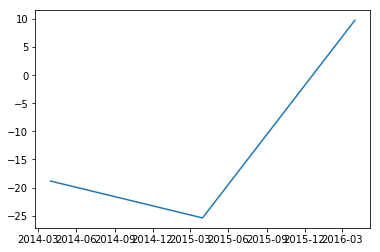

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(portfolio_1_return['Start_Date'], portfolio_1_return['value_weighted annual return'])

plt.show()

## Get Portfolio_2 Returns

In [93]:
port_2_res['value_weighted annual return'] = port_2_res['Annual Return'] * port_2_res['weights_2']

In [94]:
port_2_res

Rebalance Date       Date Ticker                       Company  \
0        2015-03-31 2016-03-31   AABA                    ALTABA INC   
1        2016-03-31 2017-03-31   AABA                    ALTABA INC   
2        2015-03-31 2016-03-31   AAMC    ALTISOURCE ASSET MGMT CORP   
3        2014-03-31 2015-03-31   AAME        ATLANTIC AMERICAN CORP   
4        2015-03-31 2016-03-31   AAME        ATLANTIC AMERICAN CORP   
5        2016-03-31 2017-03-31   AAME        ATLANTIC AMERICAN CORP   
6        2016-03-31 2017-03-31    AAN                   AARON'S INC   
7        2014-03-31 2015-03-31   AAWW  ATLAS AIR WORLDWIDE HLDG INC   
8        2015-03-31 2016-03-31   AAWW  ATLAS AIR WORLDWIDE HLDG INC   
9        2016-03-31 2017-03-31   AAWW  ATLAS AIR WORLDWIDE HLDG INC   
10       2014-03-31 2015-03-31   ABAC       RENMIN TIANLI GROUP INC   
11       2015-03-31 2016-03-31   ABAC       RENMIN TIANLI GROUP INC   
12       2016-03-31 2017-03-31   ABAC       RENMIN TIANLI GROUP INC   
13       2015-03-31 2016-03-31   ABDC         ALCENTRA CAPITAL CORP   
14       2016-03-31 2017-03-31   ABDC         ALCENTRA CAPITAL CORP   
15       2016-03-31 2017-03-31   ABEO       ABEONA THERAPEUTICS INC   
16       2016-03-31 2017-03-31   ABIO            ARCA BIOPHARMA INC   
17       2014-03-31 2015-03-31    ABR        ARBOR REALTY TRUST INC   
18       2015-03-31 2016-03-31    ABR        ARBOR REALTY TRUST INC   
19       2016-03-31 2017-03-31    ABR        ARBOR REALTY TRUST INC   
20       2016-03-31 2017-03-31   ABTX     ALLEGIANCE BANCSHARES INC   
21       2016-03-31 2017-03-31   ABUS        ARBUTUS BIOPHARMA CORP   
22       2014-03-31 2015-03-31    ABX             BARRICK GOLD CORP   
23       2015-03-31 2016-03-31    ABX             BARRICK GOLD CORP   
24       2016-03-31 2017-03-31     AC  ASSOCIATED CAPITAL GROUP INC   
25       2014-03-31 2015-03-31   ACAS          AMERICAN CAPITAL LTD   
26       2015-03-31 2016-03-31   ACAS          AMERICAN CAPITAL LTD   
27       2016-03-31 2017-03-31   ACBI   ATLANTIC CAP BANCSHARES INC   
28       2014-03-31 2015-03-31   ACCO              ACCO BRANDS CORP   
29       2016-03-31 2017-03-31   ACCO              ACCO BRANDS CORP   
...             ...        ...    ...                           ...   
3519     2016-03-31 2017-03-31     XL                  XL GROUP LTD   
3520     2015-03-31 2016-03-31   XNET              XUNLEI LTD  -ADS   
3521     2016-03-31 2017-03-31   XNET              XUNLEI LTD  -ADS   
3522     2016-03-31 2017-03-31    XPL  SOLITARIO EXPLORATION & RLTY   
3523     2016-03-31 2017-03-31   XPLR      XPLORE TECHNOLOGIES CORP   
3524     2016-03-31 2017-03-31    XPO             XPO LOGISTICS INC   
3525     2014-03-31 2015-03-31    XRX                    XEROX CORP   
3526     2016-03-31 2017-03-31    XRX                    XEROX CORP   
3527     2016-03-31 2017-03-31   XSPA            XPRESSPA GROUP INC   
3528     2014-03-31 2015-03-31      Y                ALLEGHANY CORP   
3529     2015-03-31 2016-03-31      Y                ALLEGHANY CORP   
3530     2016-03-31 2017-03-31      Y                ALLEGHANY CORP   
3531     2016-03-31 2017-03-31   YECO      YULONG ECO-MATERIALS LTD   
3532     2014-03-31 2015-03-31    YPF  YACIMIENTOS PETE FISCALES SA   
3533     2015-03-31 2016-03-31    YPF  YACIMIENTOS PETE FISCALES SA   
3534     2016-03-31 2017-03-31    YPF  YACIMIENTOS PETE FISCALES SA   
3535     2014-03-31 2015-03-31   ZAGG                      ZAGG INC   
3536     2016-03-31 2017-03-31   ZAIS          ZAIS GROUP HLDGS INC   
3537     2014-03-31 2015-03-31   ZEUS             OLYMPIC STEEL INC   
3538     2015-03-31 2016-03-31   ZEUS             OLYMPIC STEEL INC   
3539     2016-03-31 2017-03-31   ZEUS             OLYMPIC STEEL INC   
3540     2016-03-31 2017-03-31   ZFGN                    ZAFGEN INC   
3541     2016-03-31 2017-03-31   ZGNX                   ZOGENIX INC   
3542     2014-03-31 2015-03-31   ZION          ZIONS BANCORPORATION   
3543     2015-03-31 2016-03-3

In [95]:
portfolio_2_return = port_2_res.loc[:, ['Rebalance Date', 'Date', 'value_weighted annual return']].\
groupby(['Rebalance Date','Date']).sum().reset_index().copy()


In [96]:
portfolio_2_return

Rebalance Date       Date  value_weighted annual return
0     2014-03-31 2015-03-31                      0.950194
1     2015-03-31 2016-03-31                      0.864334
2     2016-03-31 2017-03-31                      1.221756

In [97]:
portfolio_2_return['Start_Date'] = portfolio_2_return['Date'].apply(lambda x: x - pd.DateOffset(years=1))

portfolio_2_return.columns = ['Rebalance Date','End_Date', 'value_weighted annual return', 'Start_Date']

portfolio_2_return = portfolio_2_return.loc[:, ['Rebalance Date', 'Start_Date', 'End_Date', 'value_weighted annual return']].copy()

portfolio_2_return.loc[:, 'value_weighted annual return'] = (portfolio_2_return.loc[:, 'value_weighted annual return'] - 1) * 100


In [98]:
portfolio_2_return

Rebalance Date Start_Date   End_Date  value_weighted annual return
0     2014-03-31 2014-03-31 2015-03-31                     -4.980573
1     2015-03-31 2015-03-31 2016-03-31                    -13.566552
2     2016-03-31 2016-03-31 2017-03-31                     22.175580

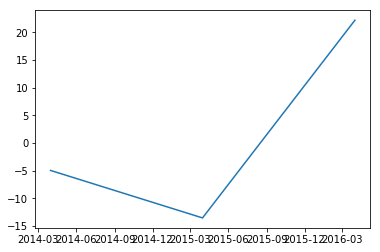

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(portfolio_2_return['Start_Date'], portfolio_2_return['value_weighted annual return'])

plt.show()

## Get Portfolio_3 Returns

In [100]:
port_3_res['value_weighted annual return'] = port_3_res['Annual Return'] * port_3_res['weights_2']

In [101]:
port_3_res

Rebalance Date       Date Ticker                       Company  \
0        2015-03-31 2016-03-31   AAMC    ALTISOURCE ASSET MGMT CORP   
1        2014-03-31 2015-03-31   AAME        ATLANTIC AMERICAN CORP   
2        2015-03-31 2016-03-31   AAME        ATLANTIC AMERICAN CORP   
3        2016-03-31 2017-03-31   AAME        ATLANTIC AMERICAN CORP   
4        2016-03-31 2017-03-31    AAN                   AARON'S INC   
5        2014-03-31 2015-03-31   AAWW  ATLAS AIR WORLDWIDE HLDG INC   
6        2015-03-31 2016-03-31   AAWW  ATLAS AIR WORLDWIDE HLDG INC   
7        2016-03-31 2017-03-31   AAWW  ATLAS AIR WORLDWIDE HLDG INC   
8        2014-03-31 2015-03-31   ABAC       RENMIN TIANLI GROUP INC   
9        2015-03-31 2016-03-31   ABAC       RENMIN TIANLI GROUP INC   
10       2016-03-31 2017-03-31   ABAC       RENMIN TIANLI GROUP INC   
11       2015-03-31 2016-03-31   ABDC         ALCENTRA CAPITAL CORP   
12       2016-03-31 2017-03-31   ABDC         ALCENTRA CAPITAL CORP   
13       2016-03-31 2017-03-31   ABEO       ABEONA THERAPEUTICS INC   
14       2016-03-31 2017-03-31   ABIO            ARCA BIOPHARMA INC   
15       2014-03-31 2015-03-31    ABR        ARBOR REALTY TRUST INC   
16       2015-03-31 2016-03-31    ABR        ARBOR REALTY TRUST INC   
17       2016-03-31 2017-03-31    ABR        ARBOR REALTY TRUST INC   
18       2016-03-31 2017-03-31   ABTX     ALLEGIANCE BANCSHARES INC   
19       2016-03-31 2017-03-31   ABUS        ARBUTUS BIOPHARMA CORP   
20       2016-03-31 2017-03-31     AC  ASSOCIATED CAPITAL GROUP INC   
21       2016-03-31 2017-03-31   ACBI   ATLANTIC CAP BANCSHARES INC   
22       2014-03-31 2015-03-31   ACCO              ACCO BRANDS CORP   
23       2016-03-31 2017-03-31   ACCO              ACCO BRANDS CORP   
24       2014-03-31 2015-03-31   ACFC   ATLANTIC COAST FINANCIAL CP   
25       2015-03-31 2016-03-31   ACFC   ATLANTIC COAST FINANCIAL CP   
26       2016-03-31 2017-03-31   ACFC   ATLANTIC COAST FINANCIAL CP   
27       2014-03-31 2015-03-31   ACLS      AXCELIS TECHNOLOGIES INC   
28       2014-03-31 2015-03-31   ACNB                     ACNB CORP   
29       2015-03-31 2016-03-31   ACNB                     ACNB CORP   
...             ...        ...    ...                           ...   
2795     2014-03-31 2015-03-31   WVFC            WVS FINANCIAL CORP   
2796     2015-03-31 2016-03-31   WVFC            WVS FINANCIAL CORP   
2797     2016-03-31 2017-03-31   WVFC            WVS FINANCIAL CORP   
2798     2016-03-31 2017-03-31   WVVI   WILLAMETTE VALLEY VINEYARDS   
2799     2015-03-31 2016-03-31    WWR       WESTWATER RESOURCES INC   
2800     2016-03-31 2017-03-31    WWR       WESTWATER RESOURCES INC   
2801     2016-03-31 2017-03-31      X      UNITED STATES STEEL CORP   
2802     2016-03-31 2017-03-31   XELB               XCEL BRANDS INC   
2803     2016-03-31 2017-03-31   XGTI             XG TECHNOLOGY INC   
2804     2016-03-31 2017-03-31    XHR    XENIA HOTELS & RESORTS INC   
2805     2014-03-31 2015-03-31    XIN   XINYUAN REAL ESTATE CO -ADR   
2806     2015-03-31 2016-03-31    XIN   XINYUAN REAL ESTATE CO -ADR   
2807     2016-03-31 2017-03-31    XIN   XINYUAN REAL ESTATE CO -ADR   
2808     2015-03-31 2016-03-31   XNET              XUNLEI LTD  -ADS   
2809     2016-03-31 2017-03-31   XNET              XUNLEI LTD  -ADS   
2810     2016-03-31 2017-03-31    XPL  SOLITARIO EXPLORATION & RLTY   
2811     2016-03-31 2017-03-31   XPLR      XPLORE TECHNOLOGIES CORP   
2812     2016-03-31 2017-03-31   XSPA            XPRESSPA GROUP INC   
2813     2016-03-31 2017-03-31   YECO      YULONG ECO-MATERIALS LTD   
2814     2014-03-31 2015-03-31   ZAGG                      ZAGG INC   
2815     2016-03-31 2017-03-31   ZAIS          ZAIS GROUP HLDGS INC   
2816     2014-03-31 2015-03-31   ZEUS             OLYMPIC STEEL INC   
2817     2015-03-31 2016-03-31   ZEUS             OLYMPIC STEEL INC   
2818     2016-03-31 2017-03-31   ZEUS             OLYMPIC STEEL INC   
2819     2016-03-31 2017-03-3

In [102]:
portfolio_3_return = port_3_res.loc[:, ['Rebalance Date', 'Date', 'value_weighted annual return']].\
groupby(['Rebalance Date','Date']).sum().reset_index().copy()


In [103]:
portfolio_3_return

Rebalance Date       Date  value_weighted annual return
0     2014-03-31 2015-03-31                      0.975410
1     2015-03-31 2016-03-31                      0.862158
2     2016-03-31 2017-03-31                      1.281860

In [104]:
portfolio_3_return['Start_Date'] = portfolio_3_return['Date'].apply(lambda x: x - pd.DateOffset(years=1))

portfolio_3_return.columns = ['Rebalance Date','End_Date', 'value_weighted annual return', 'Start_Date']

portfolio_3_return = portfolio_3_return.loc[:, ['Rebalance Date', 'Start_Date', 'End_Date', 'value_weighted annual return']].copy()

portfolio_3_return.loc[:, 'value_weighted annual return'] = (portfolio_3_return.loc[:, 'value_weighted annual return'] - 1) * 100


In [105]:
portfolio_3_return

Rebalance Date Start_Date   End_Date  value_weighted annual return
0     2014-03-31 2014-03-31 2015-03-31                     -2.458991
1     2015-03-31 2015-03-31 2016-03-31                    -13.784166
2     2016-03-31 2016-03-31 2017-03-31                     28.185982

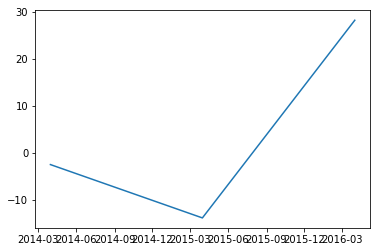

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(portfolio_3_return['Start_Date'], portfolio_3_return['value_weighted annual return'])

plt.show()

## Get Portfolio_4 Returns

In [107]:
port_4_res['value_weighted annual return'] = port_4_res['Annual Return'] * port_4_res['weights_2']

In [108]:
port_4_res

Rebalance Date       Date Ticker                       Company  \
0       2015-03-31 2016-03-31   AABA                    ALTABA INC   
1       2016-03-31 2017-03-31   AABA                    ALTABA INC   
2       2014-03-31 2015-03-31    ABX             BARRICK GOLD CORP   
3       2015-03-31 2016-03-31    ABX             BARRICK GOLD CORP   
4       2014-03-31 2015-03-31   ACAS          AMERICAN CAPITAL LTD   
5       2015-03-31 2016-03-31   ACAS          AMERICAN CAPITAL LTD   
6       2014-03-31 2015-03-31   ACGL        ARCH CAPITAL GROUP LTD   
7       2015-03-31 2016-03-31   ACGL        ARCH CAPITAL GROUP LTD   
8       2016-03-31 2017-03-31   ACGL        ARCH CAPITAL GROUP LTD   
9       2015-03-31 2016-03-31    ACM                         AECOM   
10      2016-03-31 2017-03-31    ACM                         AECOM   
11      2014-03-31 2015-03-31    ADM     ARCHER-DANIELS-MIDLAND CO   
12      2016-03-31 2017-03-31    ADM     ARCHER-DANIELS-MIDLAND CO   
13      2014-03-31 2015-03-31    AEE                   AMEREN CORP   
14      2015-03-31 2016-03-31    AEE                   AMEREN CORP   
15      2016-03-31 2017-03-31    AEE                   AMEREN CORP   
16      2014-03-31 2015-03-31    AEG                      AEGON NV   
17      2015-03-31 2016-03-31    AEG                      AEGON NV   
18      2016-03-31 2017-03-31    AEG                      AEGON NV   
19      2015-03-31 2016-03-31    AEM        AGNICO EAGLE MINES LTD   
20      2014-03-31 2015-03-31    AEP    AMERICAN ELECTRIC POWER CO   
21      2015-03-31 2016-03-31    AEP    AMERICAN ELECTRIC POWER CO   
22      2016-03-31 2017-03-31    AEP    AMERICAN ELECTRIC POWER CO   
23      2015-03-31 2016-03-31    AER            AERCAP HOLDINGS NV   
24      2016-03-31 2017-03-31    AER            AERCAP HOLDINGS NV   
25      2014-03-31 2015-03-31    AES                      AES CORP   
26      2015-03-31 2016-03-31    AES                      AES CORP   
27      2016-03-31 2017-03-31    AES                      AES CORP   
28      2014-03-31 2015-03-31    AFG  AMERICAN FINANCIAL GROUP INC   
29      2015-03-31 2016-03-31    AFG  AMERICAN FINANCIAL GROUP INC   
..             ...        ...    ...                           ...   
694     2014-03-31 2015-03-31    WPX                WPX ENERGY INC   
695     2015-03-31 2016-03-31    WPZ          WILLIAMS PARTNERS LP   
696     2016-03-31 2017-03-31    WPZ          WILLIAMS PARTNERS LP   
697     2014-03-31 2015-03-31     WR             WESTAR ENERGY INC   
698     2015-03-31 2016-03-31     WR             WESTAR ENERGY INC   
699     2016-03-31 2017-03-31     WR             WESTAR ENERGY INC   
700     2014-03-31 2015-03-31    WRB            BERKLEY (W R) CORP   
701     2016-03-31 2017-03-31    WRK                   WESTROCK CO   
702     2015-03-31 2016-03-31    WTM      WHITE MTNS INS GROUP LTD   
703     2016-03-31 2017-03-31    WTM      WHITE MTNS INS GROUP LTD   
704     2014-03-31 2015-03-31      X      UNITED STATES STEEL CORP   
705     2015-03-31 2016-03-31      X      UNITED STATES STEEL CORP   
706     2014-03-31 2015-03-31    XEL               XCEL ENERGY INC   
707     2015-03-31 2016-03-31    XEL               XCEL ENERGY INC   
708     2016-03-31 2017-03-31    XEL               XCEL ENERGY INC   
709     2014-03-31 2015-03-31     XL                  XL GROUP LTD   
710     2015-03-31 2016-03-31     XL                  XL GROUP LTD   
711     2016-03-31 2017-03-31     XL                  XL GROUP LTD   
712     2016-03-31 2017-03-31    XPO             XPO LOGISTICS INC   
713     2014-03-31 2015-03-31    XRX                    XEROX CORP   
714     2016-03-31 2017-03-31    XRX                    XEROX CORP   
715     2014-03-31 2015-03-31      Y                ALLEGHANY CORP   
716     2015-03-31 2016-03-31      Y                ALLEGHANY CORP   
717     2016-03-31 2017-03-31      Y                ALLEGHANY CORP   
718     2014-03-31 2015-03-31    YPF  YACIMIENTOS PETE FISCALES SA   
719     2015-0

In [109]:
portfolio_4_return = port_4_res.loc[:, ['Rebalance Date', 'Date', 'value_weighted annual return']].\
groupby(['Rebalance Date','Date']).sum().reset_index().copy()


In [110]:
portfolio_4_return

Rebalance Date       Date  value_weighted annual return
0     2014-03-31 2015-03-31                      0.948032
1     2015-03-31 2016-03-31                      0.864542
2     2016-03-31 2017-03-31                      1.215523

In [111]:
portfolio_4_return['Start_Date'] = portfolio_4_return['Date'].apply(lambda x: x - pd.DateOffset(years=1))

portfolio_4_return.columns = ['Rebalance Date','End_Date', 'value_weighted annual return', 'Start_Date']

portfolio_4_return = portfolio_4_return.loc[:, ['Rebalance Date', 'Start_Date', 'End_Date', 'value_weighted annual return']].copy()

portfolio_4_return.loc[:, 'value_weighted annual return'] = (portfolio_4_return.loc[:, 'value_weighted annual return'] - 1) * 100


In [112]:
portfolio_4_return

Rebalance Date Start_Date   End_Date  value_weighted annual return
0     2014-03-31 2014-03-31 2015-03-31                     -5.196812
1     2015-03-31 2015-03-31 2016-03-31                    -13.545833
2     2016-03-31 2016-03-31 2017-03-31                     21.552251

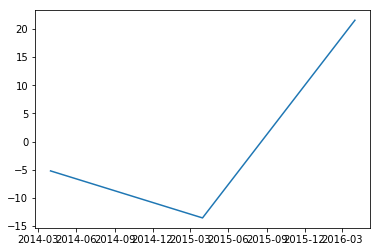

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(portfolio_4_return['Start_Date'], portfolio_4_return['value_weighted annual return'])

plt.show()

## Get BenchMark Returns

In [114]:
benchmark_res['value_weighted annual return'] = benchmark_res['Annual Return'] * benchmark_res['weights']
benchmark_res.head()


Date Ticker                       Company  Stock Exchange Code_x  \
0 2017-03-31   AAAP  ADVANCED ACCELERATR APP -ADR                     14   
1 2015-03-31   AABA                    ALTABA INC                     14   
2 2016-03-31   AABA                    ALTABA INC                     14   
3 2017-03-31   AABA                    ALTABA INC                     14   
4 2016-03-31    AAC              AAC HOLDINGS INC                     11   

   GICS Sector  M Total Return  S_Period  Annual Return Rebalance Date  \
0         35.0        1.050606         3       1.138205     2016-03-31   
1         45.0        1.003500         1       1.237744     2014-03-31   
2         45.0        1.157911         2       0.828401     2015-03-31   
3         45.0        1.016426         3       1.260798     2016-03-31   
4         35.0        0.970098         2       0.647155     2015-03-31   

   Stock Exchange Code_y            ME         BE     BE/ME       PB Group1  \
0                     14   1375.515560    197.113  0.143301    2.059  Small   
1                     14  36285.207000  12963.204  0.357259  180.119    Big   
2                     14  41646.037225  46623.380  1.119515   95.847    Big   
3                     14  34905.045690  28515.172  0.816936    9.788    Big   
4                     11    666.062980     98.961  0.148576    6.395  Small   

   Group2   weights  value_weighted annual return  
0  Growth  0.000055                      0.000062  
1  Growth  0.001468                      0.001817  
2   Value  0.001557                      0.001289  
3   Value  0.001387                      0.001749  
4  Growth  0.000025                      0.000016

In [115]:
benchmark_return = benchmark_res.loc[:, ['Rebalance Date', 'Date', 'value_weighted annual return']].\
groupby(['Rebalance Date','Date']).sum().reset_index().copy()
benchmark_return

Rebalance Date       Date  value_weighted annual return
0     2014-03-31 2015-03-31                      1.059792
1     2015-03-31 2016-03-31                      0.955211
2     2016-03-31 2017-03-31                      1.165981

In [116]:
benchmark_return['Start_Date'] = benchmark_return['Date'].apply(lambda x: x - pd.DateOffset(years=1))

benchmark_return.columns = ['Rebalance Date','End_Date', 'value_weighted annual return', 'Start_Date']

benchmark_return = benchmark_return.loc[:, ['Rebalance Date', 'Start_Date', 'End_Date', 'value_weighted annual return']].copy()

benchmark_return.loc[:, 'value_weighted annual return'] = (benchmark_return.loc[:, 'value_weighted annual return'] - 1) * 100

benchmark_return

Rebalance Date Start_Date   End_Date  value_weighted annual return
0     2014-03-31 2014-03-31 2015-03-31                      5.979228
1     2015-03-31 2015-03-31 2016-03-31                     -4.478908
2     2016-03-31 2016-03-31 2017-03-31                     16.598136

# *Answers*

In [117]:
print('Portfolio 1 : Select the stocks in the smallest 10% of market capitalization. Portfolios should be value weighted.\n')
print('Portfolio 2 : Select the stocks in the top 35% percentile based on Book-to-Market ratio (B/M) and form a value-weighted portfolio.\n')
print('Portfolio 3 : The smallest 50% of the stocks and form two separate Value portfolios\n')
print('Portfolio 4 : The largest 50% of the stocks and and form two separate Value portfolios\n')


Portfolio 1 : Select the stocks in the smallest 10% of market capitalization. Portfolios should be value weighted.

Portfolio 2 : Select the stocks in the top 35% percentile based on Book-to-Market ratio (B/M) and form a value-weighted portfolio.

Portfolio 3 : The smallest 50% of the stocks and form two separate Value portfolios

Portfolio 4 : The largest 50% of the stocks and and form two separate Value portfolios



In [118]:
p1 = portfolio_1_return
p2 = portfolio_2_return['value_weighted annual return']
p3 = portfolio_3_return['value_weighted annual return']
p4 = portfolio_4_return['value_weighted annual return']

final_results = pd.concat([p1, p2, p3, p4], axis=1).copy()
final_results.columns = ['Rebalance Date', 'Start_Date', 'End_Date', 'Portfolio 1', 'Portfolio 2', 'Portfolio 3', 'Portfolio 4']
final_results

Rebalance Date Start_Date   End_Date  Portfolio 1  Portfolio 2  Portfolio 3  \
0     2014-03-31 2014-03-31 2015-03-31   -18.847721    -4.980573    -2.458991   
1     2015-03-31 2015-03-31 2016-03-31   -25.405583   -13.566552   -13.784166   
2     2016-03-31 2016-03-31 2017-03-31     9.774707    22.175580    28.185982   

   Portfolio 4  
0    -5.196812  
1   -13.545833  
2    21.552251

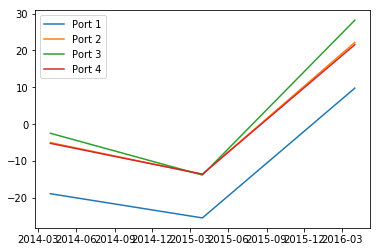

In [119]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(portfolio_1_return['Start_Date'], portfolio_1_return['value_weighted annual return'])
plt.plot(portfolio_2_return['Start_Date'], portfolio_2_return['value_weighted annual return'])
plt.plot(portfolio_3_return['Start_Date'], portfolio_3_return['value_weighted annual return'])
plt.plot(portfolio_4_return['Start_Date'], portfolio_4_return['value_weighted annual return'])
plt.legend(['Port 1', 'Port 2', 'Port 3', 'Port 4'])
plt.show()

## Risk Free Ratio (Treasury bills - 3 months)

In [121]:
tr_df = pd.read_csv("/Users/daham/Desktop/Quantitative Investment/good_projects_for_git/Portfolio_using_Fama_French_factor/treasury_bill.csv")


In [122]:
tr_df = tr_df.loc[:, ['MCALDT', 'TMYTM']]
tr_df.head()

MCALDT     TMYTM
0  03/31/2014  0.030418
1  04/30/2014  0.030418
2  05/30/2014  0.030418
3  06/30/2014  0.022813
4  07/31/2014  0.022813

In [123]:
risk_free = tr_df['TMYTM'].mean()*12
risk_free

2.0932170245513513

## Sharpe Ratio

In [124]:
final_results['Portfolio 1'].mean()

-11.492865431989394

In [125]:
avg_returns_port1 = final_results['Portfolio 1'].mean()
avg_returns_port2 = final_results['Portfolio 2'].mean()
avg_returns_port3 = final_results['Portfolio 3'].mean()
avg_returns_port4 = final_results['Portfolio 4'].mean()
print("avg_returns_port1: ", avg_returns_port1,'%')
print("avg_returns_port2: ", avg_returns_port2,'%')
print("avg_returns_port3: ", avg_returns_port3,'%')
print("avg_returns_port4: ", avg_returns_port4,'%\n')


std_port1 = final_results['Portfolio 1'].std()
std_port2 = final_results['Portfolio 2'].std()
std_port3 = final_results['Portfolio 3'].std()
std_port4 = final_results['Portfolio 4'].std()
print("std_port1: ", std_port1,'%')
print("std_port2: ", std_port2,'%')
print("std_port3: ", std_port3,'%')
print("std_port4: ", std_port4,'%\n')

sharpe_port1 = (avg_returns_port1 - risk_free)/std_port1
sharpe_port2 = (avg_returns_port2 - risk_free)/std_port2 
sharpe_port3 = (avg_returns_port3 - risk_free)/std_port3 
sharpe_port4 = (avg_returns_port4 - risk_free)/std_port4 
print("sharpe_port1: ", sharpe_port1)
print("sharpe_port2: ", sharpe_port2)
print("sharpe_port3: ", sharpe_port3)
print("sharpe_port4: ", sharpe_port4)

avg_returns_port1:  -11.492865432 %
avg_returns_port2:  1.20948488036 %
avg_returns_port3:  3.98094150525 %
avg_returns_port4:  0.936535371119 %

std_port1:  18.7078494123 %
std_port2:  18.6577763793 %
std_port3:  21.7135411479 %
std_port4:  18.3352756943 %

sharpe_port1:  -0.72622363785
sharpe_port2:  -0.0473653519167
sharpe_port3:  0.0869376610588
sharpe_port4:  -0.0630850428823


## Bench Mark

In [126]:
benchmark_return

Rebalance Date Start_Date   End_Date  value_weighted annual return
0     2014-03-31 2014-03-31 2015-03-31                      5.979228
1     2015-03-31 2015-03-31 2016-03-31                     -4.478908
2     2016-03-31 2016-03-31 2017-03-31                     16.598136

## Sharpe Ratio of BenchMark

In [127]:
avg_benchmark_return = benchmark_return['value_weighted annual return'].mean()
print("avg_benchmark_return: ", avg_benchmark_return,'%\n')

std_benchmark = benchmark_return['value_weighted annual return'].std()
print("std_benchmark: ", std_benchmark,'%\n')

sharpe_benchmark = (avg_benchmark_return - risk_free)/std_benchmark
print("sharpe_benchmark: ", sharpe_benchmark)

avg_benchmark_return:  6.03281837027 %

std_benchmark:  10.5386241658 %

sharpe_benchmark:  0.373825015839


## Alphas (CAPM)

In [128]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/Users/daham/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [129]:
def array_to_dataframe(array1, array2):
    data = np.array([array1, array2]).T
    tmp = pd.DataFrame(data=data, columns=['Y', 'X'])
    return tmp

In [130]:
# dataframe to use linear regression
port1_df_reg = array_to_dataframe(final_results['Portfolio 1'], benchmark_return['value_weighted annual return'])
port2_df_reg = array_to_dataframe(final_results['Portfolio 2'], benchmark_return['value_weighted annual return'])
port3_df_reg = array_to_dataframe(final_results['Portfolio 3'], benchmark_return['value_weighted annual return'])
port4_df_reg = array_to_dataframe(final_results['Portfolio 4'], benchmark_return['value_weighted annual return'])


In [131]:
capm_port1 = smf.ols('Y~X',data=port1_df_reg).fit()
capm_port2 = smf.ols('Y~X',data=port2_df_reg).fit()
capm_port3 = smf.ols('Y~X',data=port3_df_reg).fit()
capm_port4 = smf.ols('Y~X',data=port4_df_reg).fit()


# capm_port1.summary()
# capm_port2.summary()
# capm_port3.summary()
capm_port4.summary()

/Users/daham/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     11.27
Date:                Sun, 15 Apr 2018   Prob (F-statistic):              0.184
Time:                        22:12:17   Log-Likelihood:                -8.6143
No. Observations:                   3   AIC:                             21.23
Df Residuals:                       1   BIC:                             19.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.1227      5.220     -1.748      0.331     -75.443      57.198
X              1.6674      0.497      3.357      0.184      -4.643       7.978
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.508
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                          -0.707   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                         12.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Alphas (summary)

#### Portfolio1's alpha: -21.5738
#### Portfolio2's alpha: -9.0342
#### Portfolio3's alpha: -8.0459
#### Portfolio4's alpha: -9.1227